### Goal: Feature Importance.

The idea is to use the permutation importance to the neural network.
1. Fit the model with all the features of interest.
2. For each column:
  - Randomly permute the values in the column
  - Compute the drop in training RMSE
  - The more important the feature is, theoretically the more is the performance drop.

In [2]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.metrics import mean_squared_error;

2.6.0


In [3]:
pd.set_option('display.max_columns', 300);
pd.set_option('display.max_rows', 300);
tf.keras.backend.set_floatx('float64');

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [5]:
MONTHS = 60;
SPLIT = 48; # 2015-2018: training, 2019: testing.
# BATCH_SIZE = 19; # used in NN_v1
BATCH_SIZE = 24;
WINDOW_SIZE = 12;

TEST_LENGTH = MONTHS - SPLIT;

### Data preparation

In [6]:
multi_data = pd.read_csv('../data/full_dataset_unscaled.csv', index_col = 0);
zip_ids = multi_data.index.unique();

multi_data.drop(["City", "State", "Metro", "CountyName", "year", "month", "datetime"],\
                 axis = 1, inplace = True);

multi_data.head()

zri  percent_white  percent_black  percent_asian  percent_hispanic  \
zip                                                                          
1013  946.0       0.714892       0.023829       0.013748          0.230129   
1013  950.0       0.715367       0.024195       0.014023          0.229024   
1013  958.0       0.715842       0.024561       0.014299          0.227919   
1013  958.0       0.716318       0.024927       0.014574          0.226813   
1013  955.0       0.716793       0.025294       0.014850          0.225708   

      percent_native_am  percent_other_race  percent_0_17  percent_18_39  \
zip                                                                        
1013           0.000113            0.004539      0.224062       0.314378   
1013           0.000226            0.004587      0.223443       0.316319   
1013           0.000339            0.004634      0.222823       0.318260   
1013           0.000452            0.004682      0.222204       0.320201   
1013           0.000565            0.004730      0.221584       0.322142   

      percent_40_64  percent_65+  percent_rental_units_vacant  \
zip                                                             
1013       0.316595     0.144965                     0.057735   
1013       0.315346     0.144892                     0.057503   
1013       0.314097     0.144820                     0.057270   
1013       0.312847     0.144748                     0.057038   
1013       0.311598     0.144675                     0.056805   

      percent_rental_units_occupied  percent_graduate_deg  percent_bachelors  \
zip                                                                            
1013                       0.942265              0.029555           0.062456   
1013                       0.942497              0.029598           0.062682   
1013                       0.942730              0.029641           0.062908   
1013                       0.942962              0.029684           0.063134   
1013                       0.943195              0.029727           0.063359   

      percent_associates  percent_highschool  percent_less_highschool  \
zip                                                                     
1013            0.257328            0.383459                 0.218492   
1013            0.255708            0.385186                 0.217890   
1013            0.254088            0.386912                 0.217289   
1013            0.252468            0.388639                 0.216687   
1013            0.250848            0.390365                 0.216086   

      percent_commute_public_transport  percent_commute_less_30  \
zip                                                               
1013                          0.022609                 0.731245   
1013                          0.023198                 0.733361   
1013                          0.023787                 0.735477   
1013                          0.024375                 0.737593   
1013                          0.024964                 0.739709   

      percent_buildings_less_10_units  percent_buildings_10_19_units  \
zip                                                                    
1013                         0.883422                       0.030202   
1013                         0.883598                       0.030477   
1013                         0.883775                       0.030752   
1013                         0.883952                       0.031027   
1013                         0.884128                       0.031302   

      percent_buildings_20_49_units  percent_buildings_50+_units  \
zip                                                                
1013                       0.036863                     0.049514   
1013                       0.036368                     0.049557   
1013                       0.035873                     0.049601   
1013                       0.035378                     0.049644   
1013            

In [7]:
FEATURES = multi_data.shape[1] - 1;

feature_name = list(multi_data.columns);

### Utility functions

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series); #(43,)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True);
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)); #(13,43)
    dataset = dataset.shuffle(shuffle_buffer)\
                     .map(lambda window: (window[:-1, 1:], window[-1][0]));
    dataset = dataset.batch(batch_size).prefetch(1);
    return dataset;

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Frame")
    plt.ylabel("ZRI")
    plt.grid(True)

### Neural network center

In [10]:
def NN_model(dataset, termination=0, test = None):
    tf.keras.backend.clear_session();
    # dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    class myCallbacks(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            mse = logs.get("mse");
            if(mse < termination):
                print("\nGot an mse at {:.4f} in epoch {} and stopped training\n".format(mse, epoch));
                self.model.stop_training = True;
            
    callback = myCallbacks();
    
    model = tf.keras.models.Sequential([
#         tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                           input_shape=[None]),
#       tf.keras.layers.Conv1D(filters=32, kernel_size=3,
#                           strides=1, padding="causal",
#                           activation="relu",
#                           input_shape=[None, WINDOW_SIZE, FEATURES+1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, input_shape = [None, WINDOW_SIZE, FEATURES])),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        # tf.keras.layers.SimpleRNN(8, return_sequences=True),
        #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
        tf.keras.layers.Dense(8, activation="relu"),
    #   tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1)
        # tf.keras.layers.Lambda(lambda x: x * 2.0)
    ]);
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer="adam",
                  metrics=["mae", "mse"])

    model.build((None,WINDOW_SIZE,FEATURES))
    # model.summary()

    if not test: history = model.fit(dataset, epochs=500, callbacks = [callback], verbose = 0);
    else: history = model.fit(dataset, epochs=500, validation_data=test,\
                              callbacks=[callback], verbose = 0);
    return model;

In [11]:
def NN_forecast(model, series_transformed):
    forecast = []
    results = []
    for time in range(MONTHS - WINDOW_SIZE):
        forecast.append(model.predict(series_transformed[np.newaxis, time:time + WINDOW_SIZE, 1:]))

    results = [float(x[-1][0]) for x in forecast];
    actual = list(series_transformed[WINDOW_SIZE:, 0]);
    
    return results, actual;

In [12]:
@tf.autograph.experimental.do_not_convert
def NN_test(ZONE, termination=0, plot=False):
    '''
    Input: ZONE
    Output: the RMSE of a NN model on the predicted train, partially predicted test, and complete predicted test.
    '''
    # Collection of data
    series_frame = multi_data[multi_data.index == ZONE];
    # series_frame.sort_values("datetime", ascending = True, inplace = True);
    
    # Standardization
    scaler = MinMaxScaler();
    series_transformed = scaler.fit_transform(series_frame);
    
    # Train test split
    series_train = series_transformed[:SPLIT];
    series_test = series_transformed[SPLIT-WINDOW_SIZE:];
    
    # Window the training set to make input of the NN
    dataset_train = windowed_dataset(series_train, WINDOW_SIZE, BATCH_SIZE, 60);
    # dataset_test = windowed_dataset(series_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
#     for x, y in dataset_train:
#         print(np.array(x).shape, np.array(y).shape);
    
    model = NN_model(dataset_train, termination);
    
    time_train = list(range(SPLIT));
    time_test = list(range(SPLIT, MONTHS));
    
    # Forecasting
    results, actual = NN_forecast(model, series_transformed);
    
    # Compute MSE
    MSE_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * scaler.data_range_[0];
    MSE_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * scaler.data_range_[0];
    
    if plot: # If the plot option is selected, plot the graph.
        time_actual = range(WINDOW_SIZE, MONTHS);
        plt.figure(figsize=(10, 6))
        plot_series(time_actual, np.array(actual)*scaler.data_range_[0]+scaler.data_min_[0]);
        plot_series(time_actual, np.array(results)*scaler.data_range_[0]+scaler.data_min_[0]);
        plt.show();

    return MSE_train, MSE_test, model, scaler, series_transformed;

### The script


Got an mse at 0.0025 in epoch 128 and stopped training



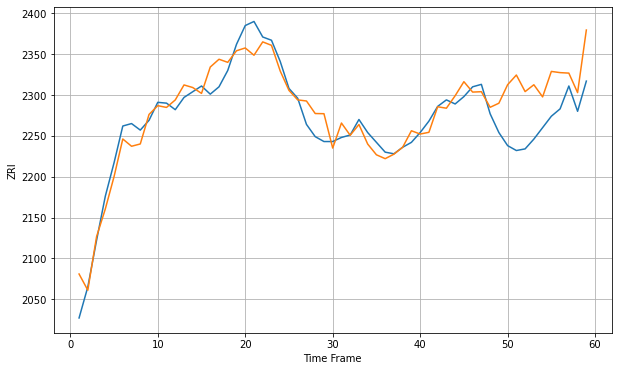

Wall time: 9.54 s
11225 17.97475163036519 54.68027993522228


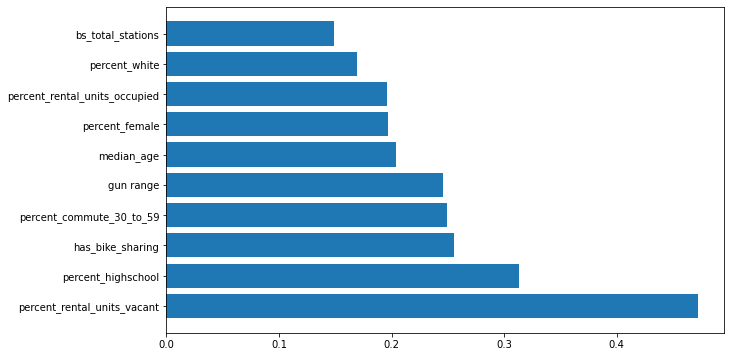


Got an mse at 0.0024 in epoch 69 and stopped training



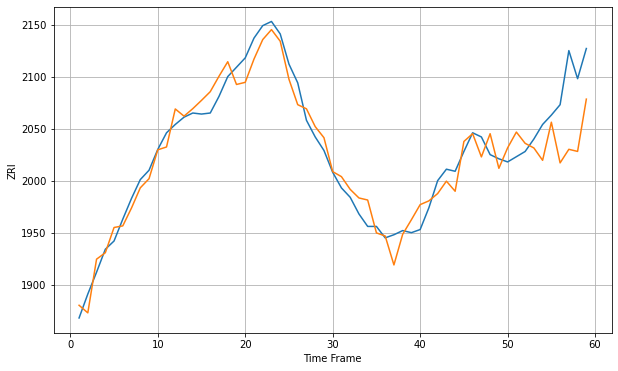

Wall time: 9.9 s
11226 13.879104919525348 42.80410141427963


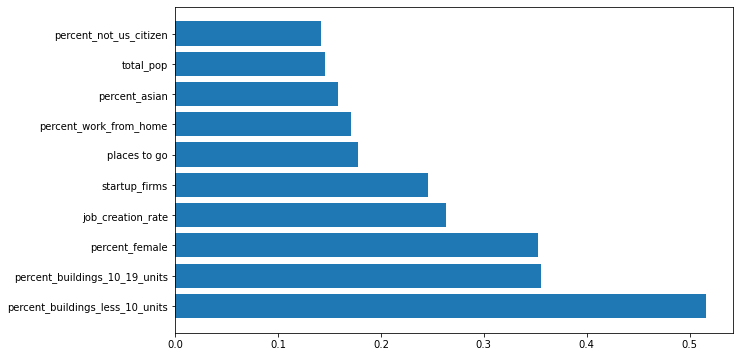


Got an mse at 0.0025 in epoch 72 and stopped training



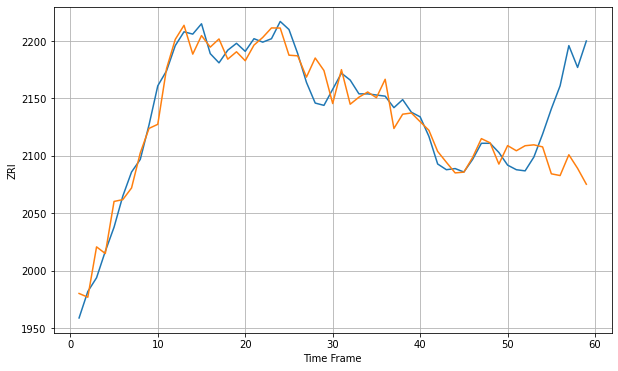

Wall time: 10.2 s
11228 13.765988369861933 59.818079778323394


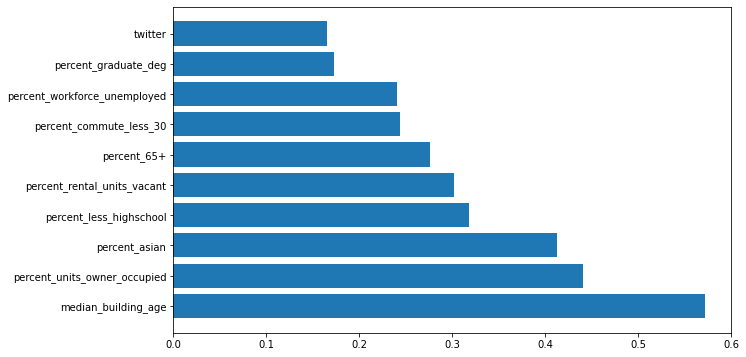


Got an mse at 0.0024 in epoch 115 and stopped training



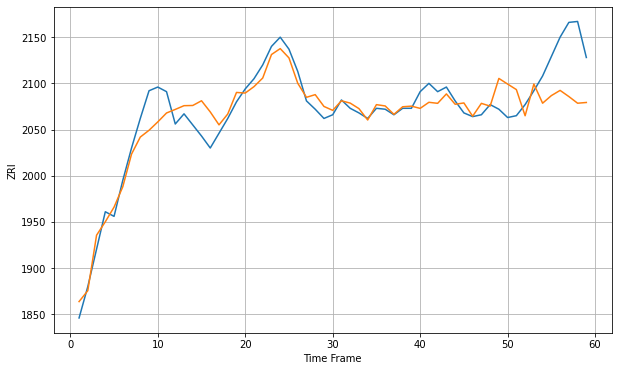

Wall time: 12.1 s
11229 15.710336669891399 46.58915400815842


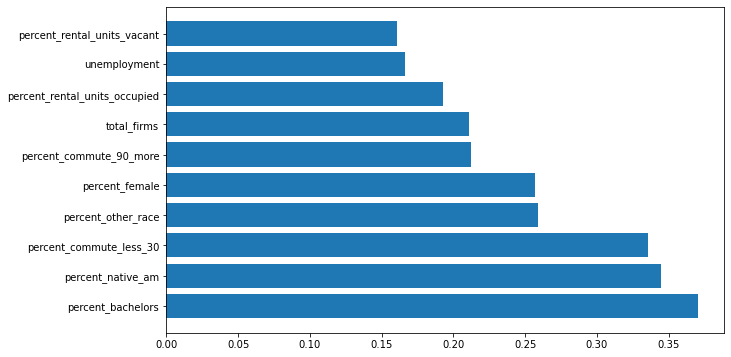


Got an mse at 0.0025 in epoch 100 and stopped training



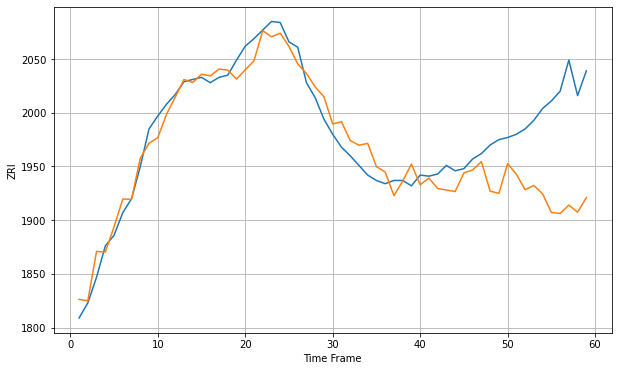

Wall time: 10.9 s
11230 13.617121007955092 85.21450349276789


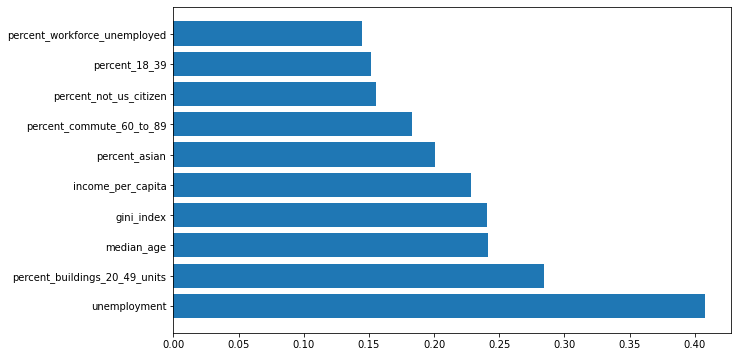


Got an mse at 0.0025 in epoch 135 and stopped training



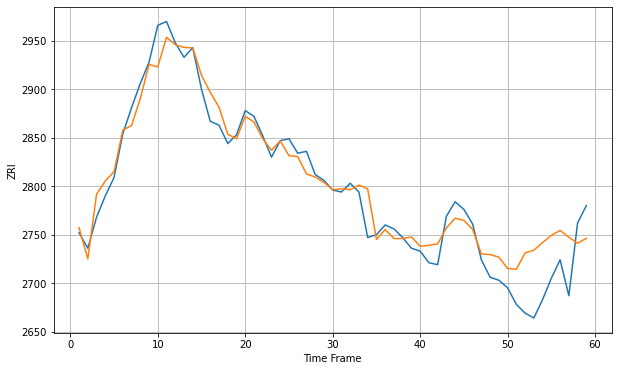

Wall time: 11.4 s
11231 15.100956278109695 43.93626147480331


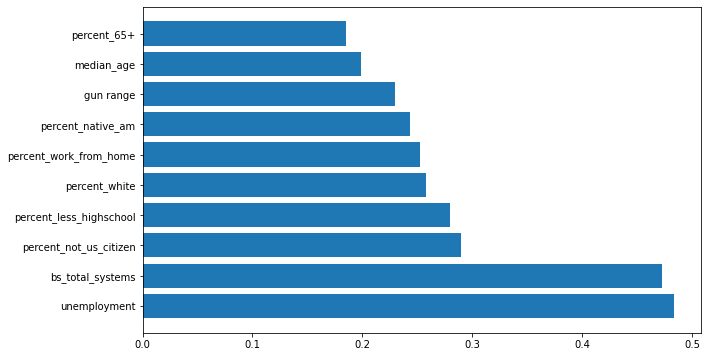


Got an mse at 0.0024 in epoch 67 and stopped training



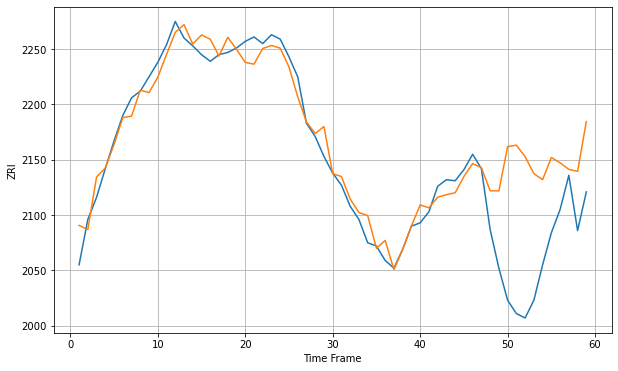

Wall time: 9.99 s
11232 12.845662749299299 92.28542655340307


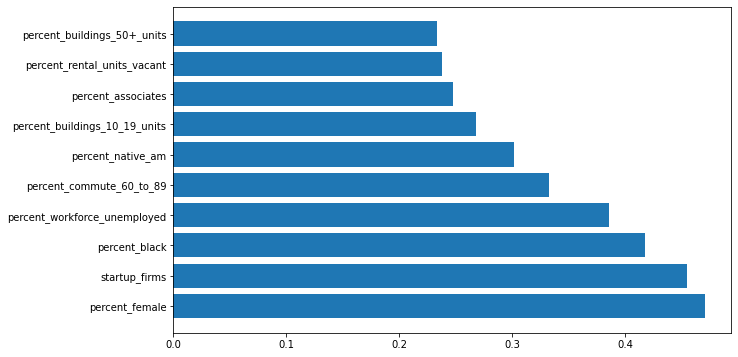


Got an mse at 0.0025 in epoch 90 and stopped training



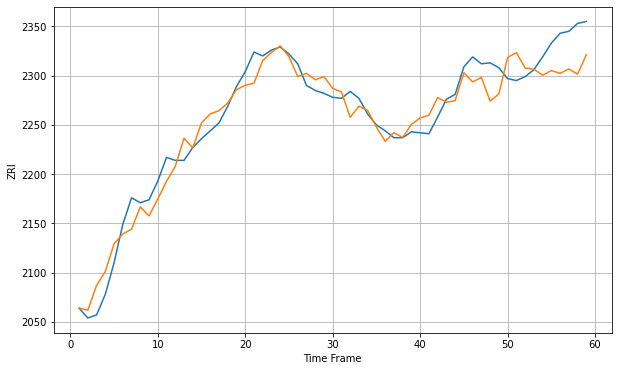

Wall time: 10.7 s
11233 14.875677397600088 31.054372499648682


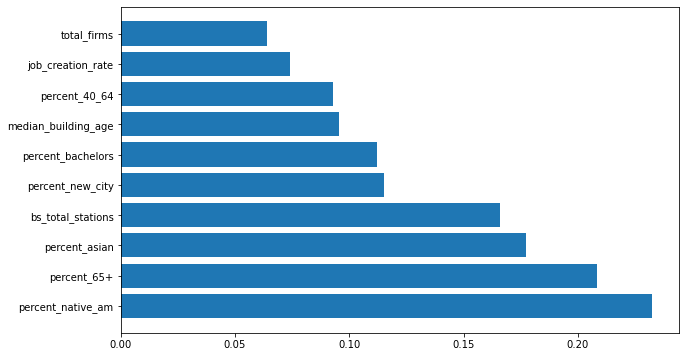


Got an mse at 0.0024 in epoch 38 and stopped training



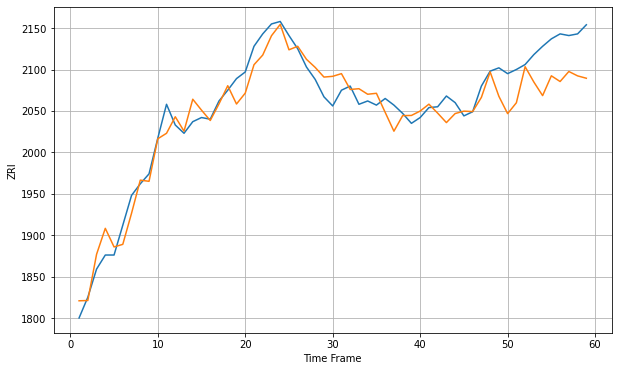

Wall time: 10.3 s
11234 17.60369445952894 44.436085288397166


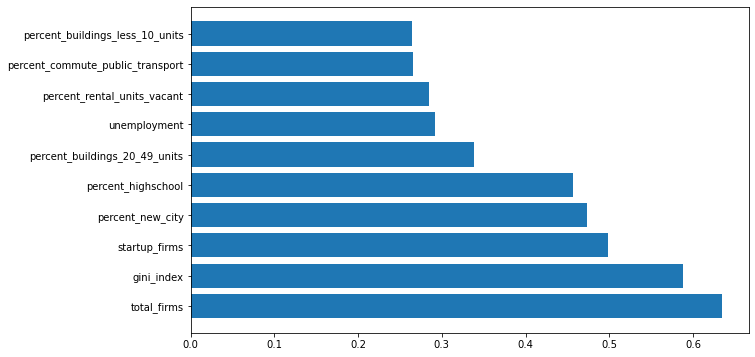


Got an mse at 0.0025 in epoch 157 and stopped training



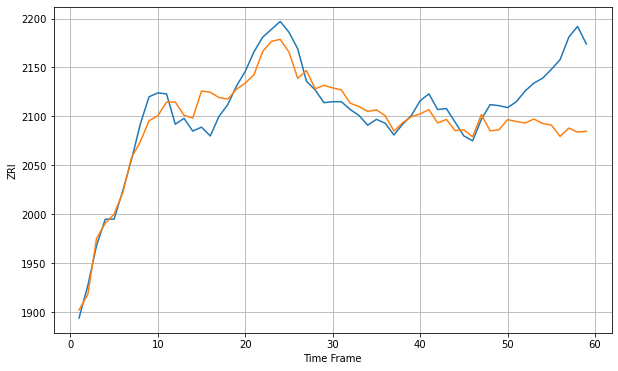

Wall time: 12.8 s
11235 15.38837738879574 60.62969480390756


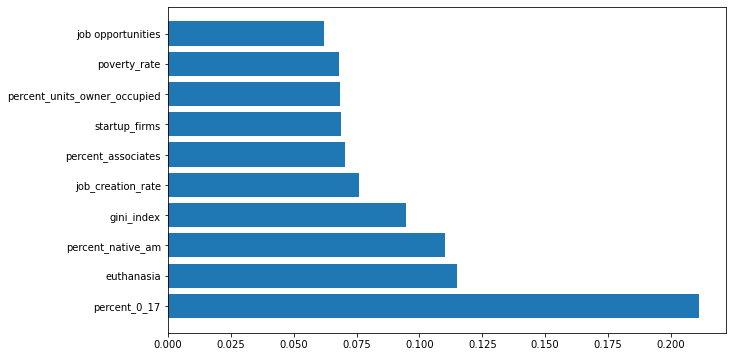


Got an mse at 0.0025 in epoch 134 and stopped training



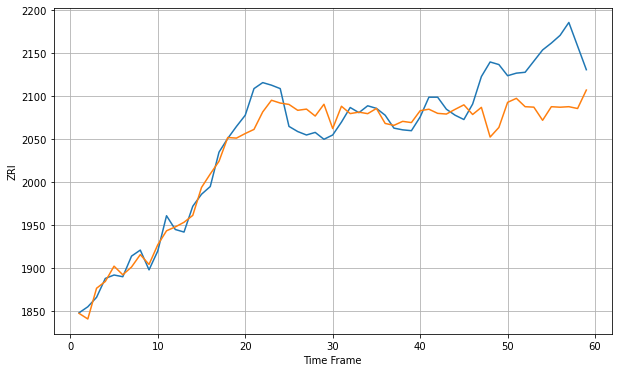

Wall time: 11.3 s
11236 17.100262832771694 67.04808916838459


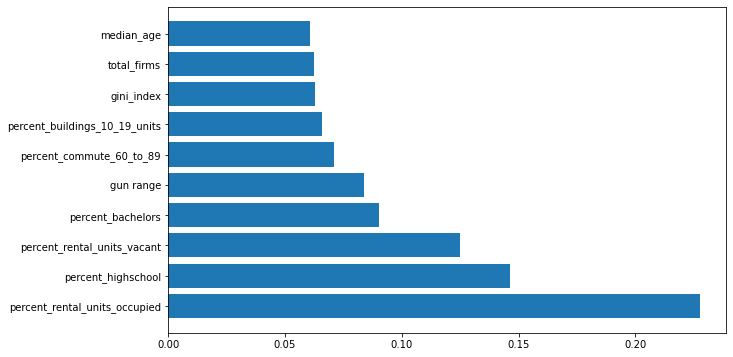


Got an mse at 0.0025 in epoch 97 and stopped training



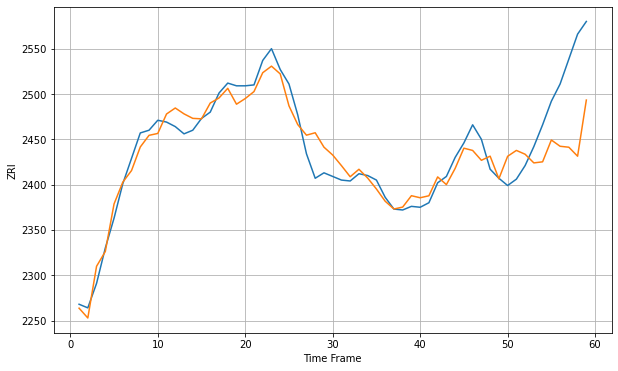

Wall time: 10.2 s
11237 15.555909647320684 61.95675318878059


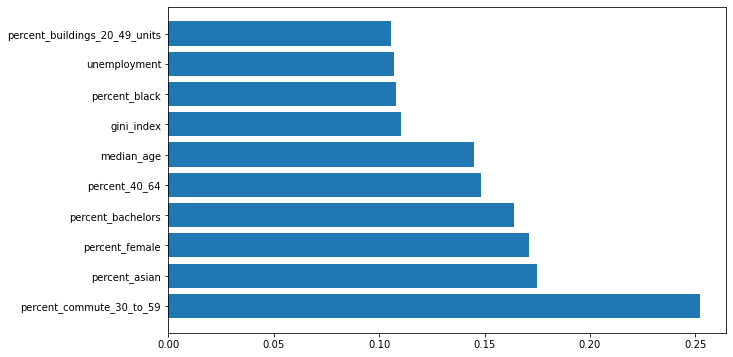


Got an mse at 0.0025 in epoch 128 and stopped training



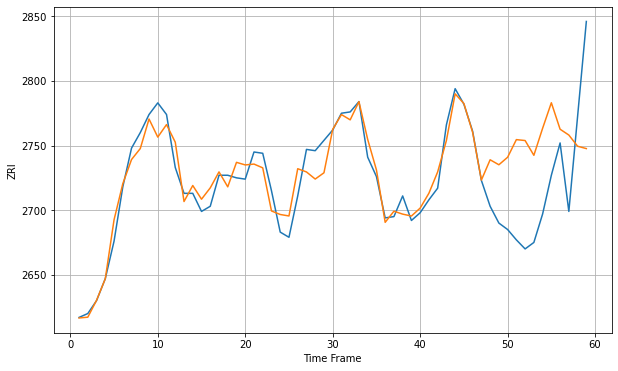

Wall time: 11.3 s
11238 11.322100502961076 61.51843993636325


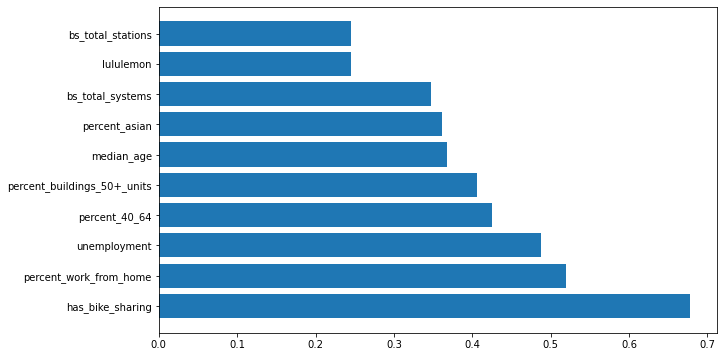


Got an mse at 0.0025 in epoch 80 and stopped training



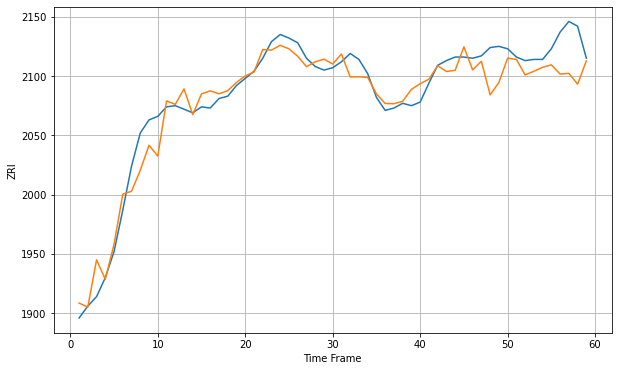

Wall time: 9.95 s
11354 12.355665366857531 26.787654858991232


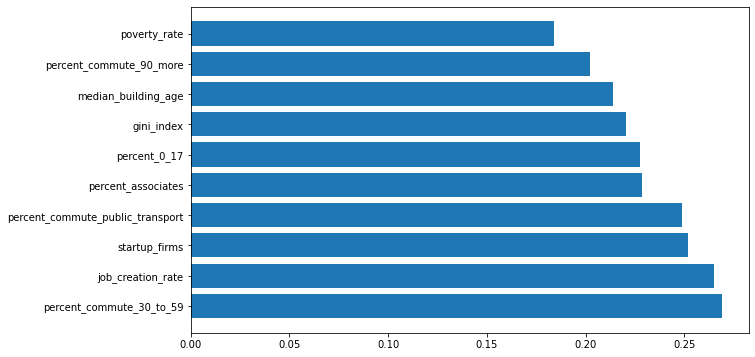


Got an mse at 0.0025 in epoch 69 and stopped training



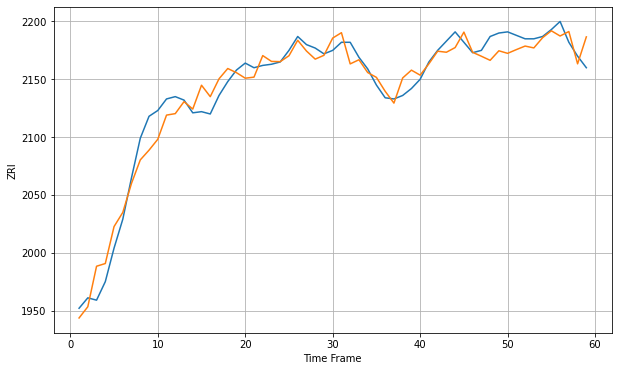

Wall time: 9.45 s
11355 12.170768169694048 13.726330568148677


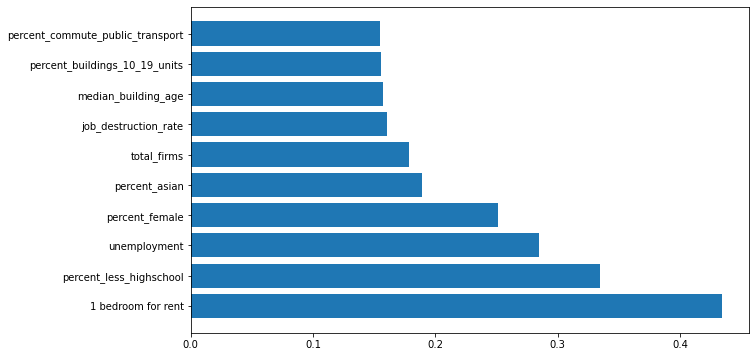


Got an mse at 0.0025 in epoch 81 and stopped training



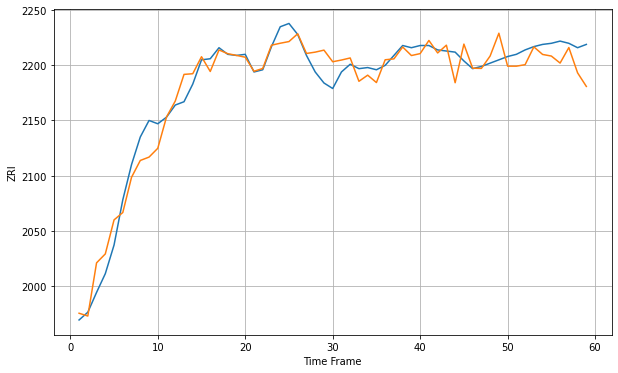

Wall time: 9.97 s
11356 13.656934334022624 17.31537763136973


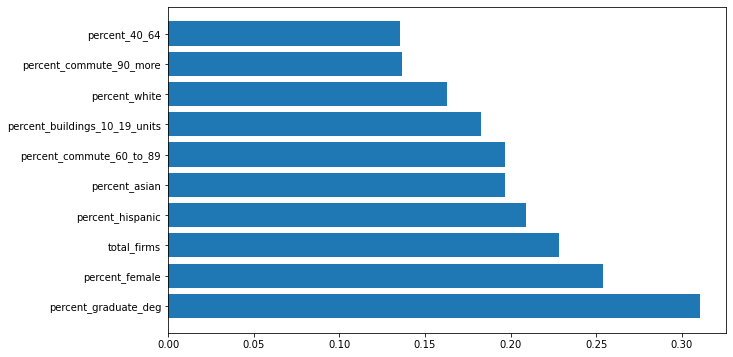

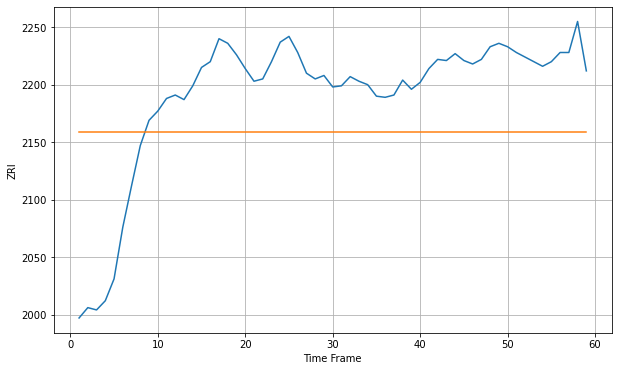

Wall time: 22 s
11357 69.77789871311056 69.51146316248416


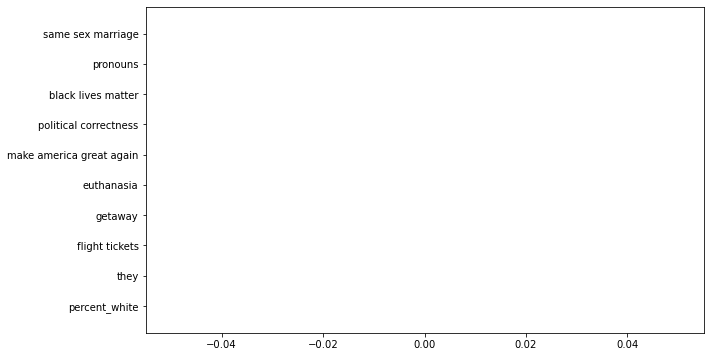


Got an mse at 0.0025 in epoch 89 and stopped training



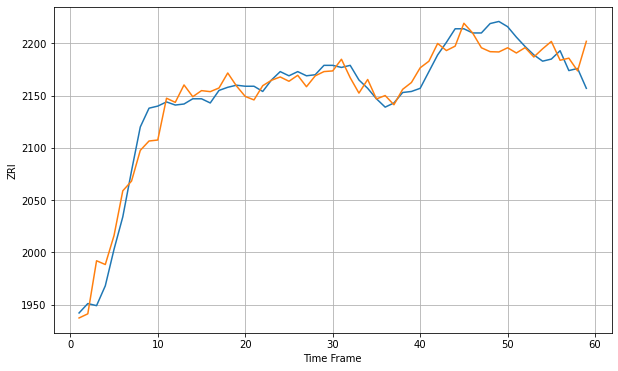

Wall time: 10.1 s
11358 13.752395242642478 20.204370614094476


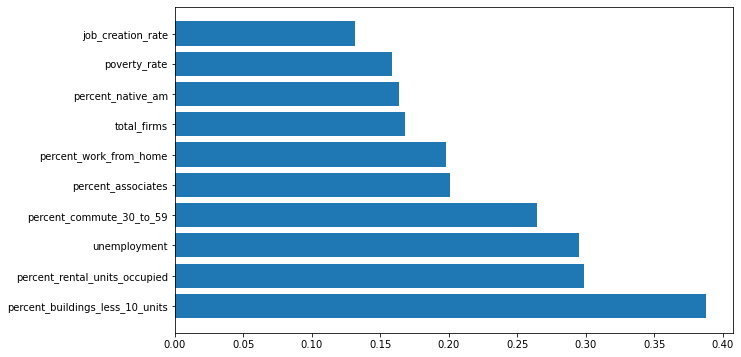


Got an mse at 0.0024 in epoch 44 and stopped training



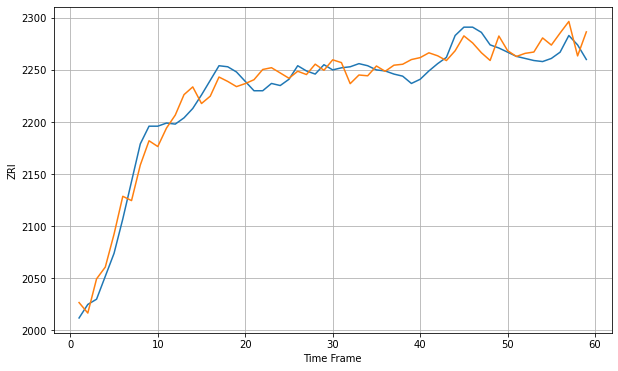

Wall time: 8.75 s
11360 13.695315207286544 14.312085237402888


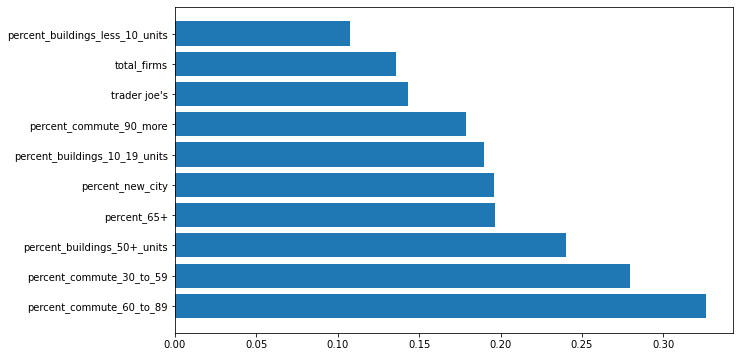


Got an mse at 0.0025 in epoch 96 and stopped training



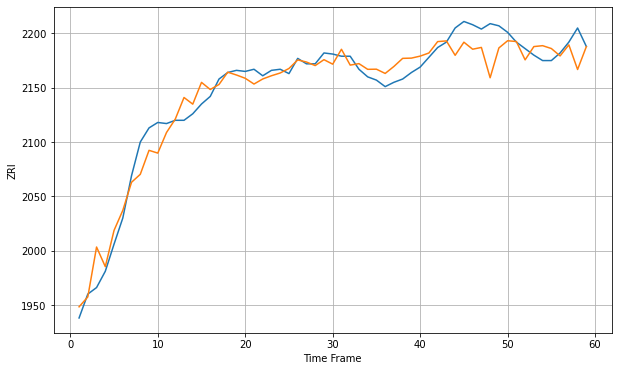

Wall time: 10.2 s
11361 13.441051689715396 20.238257598306557


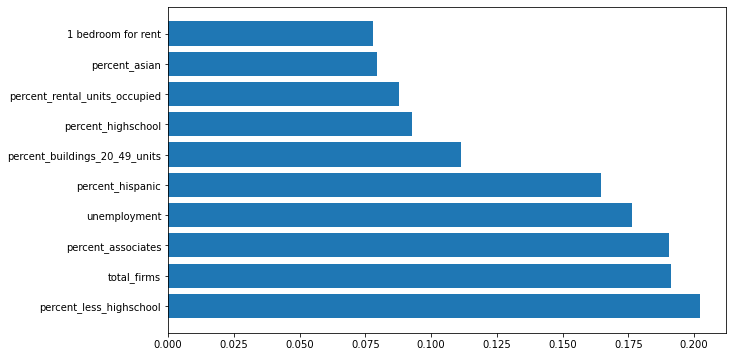


Got an mse at 0.0025 in epoch 63 and stopped training



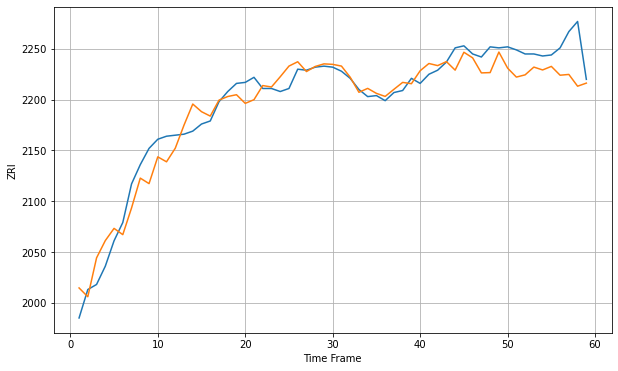

Wall time: 9.25 s
11364 14.34633407218745 27.84480149242528


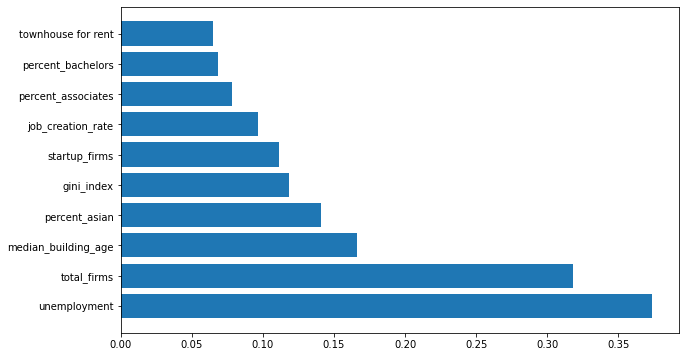


Got an mse at 0.0025 in epoch 48 and stopped training



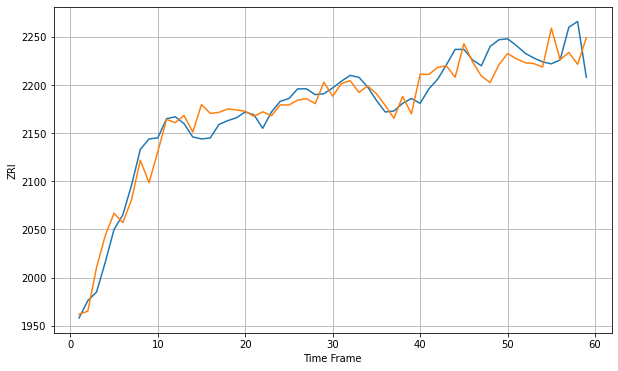

Wall time: 8.77 s
11365 15.224767025455302 26.416059182308338


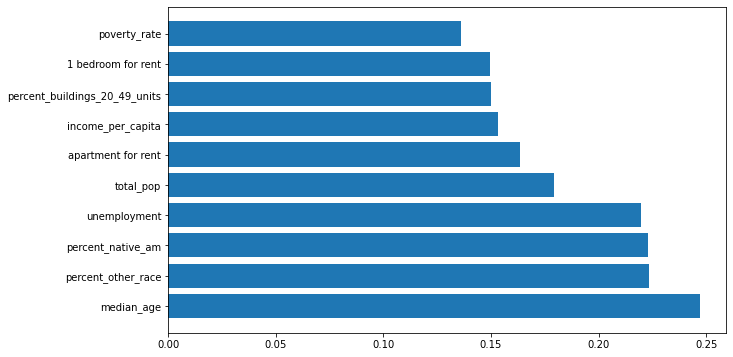


Got an mse at 0.0025 in epoch 82 and stopped training



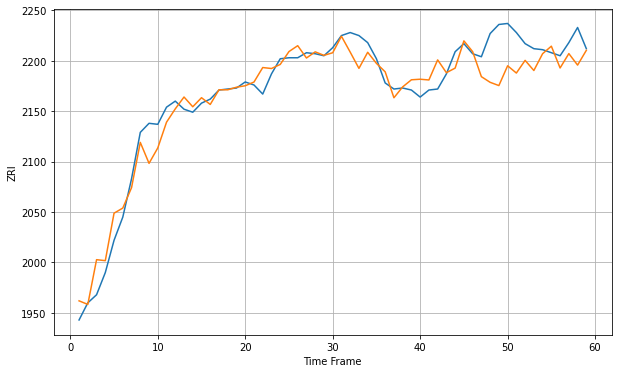

Wall time: 9.83 s
11366 14.663752556746878 31.413025925776463


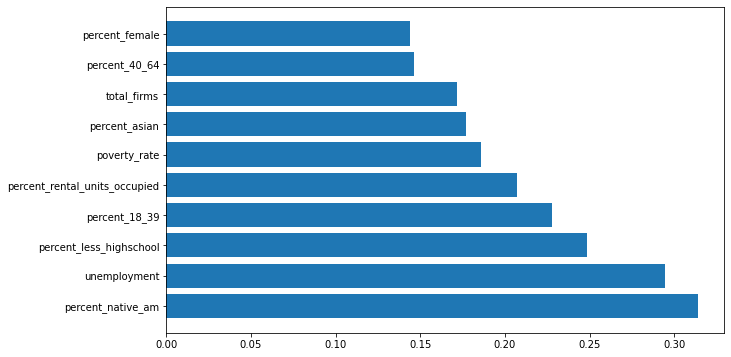


Got an mse at 0.0025 in epoch 86 and stopped training



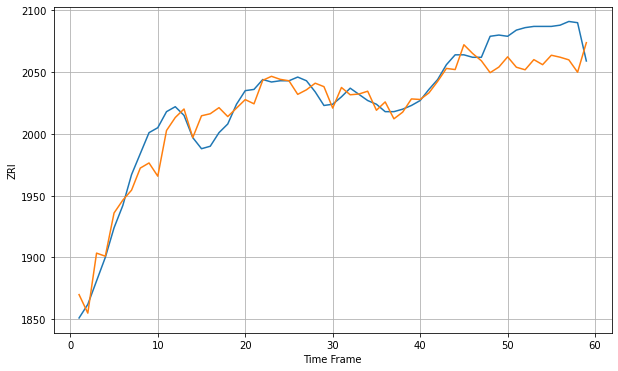

Wall time: 10 s
11367 12.204066021420156 28.244777010753005


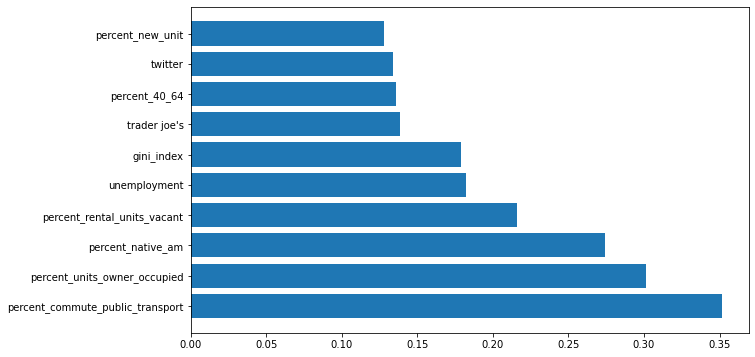


Got an mse at 0.0025 in epoch 64 and stopped training



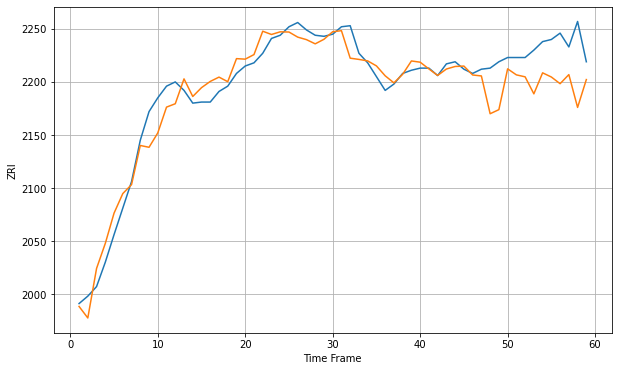

Wall time: 9.14 s
11368 13.247221518629924 38.97434643179311


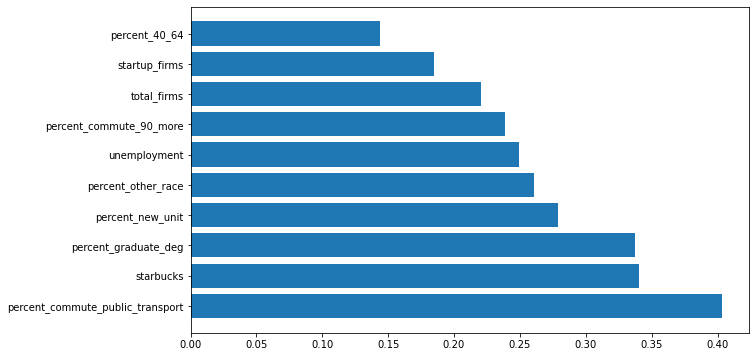


Got an mse at 0.0024 in epoch 59 and stopped training



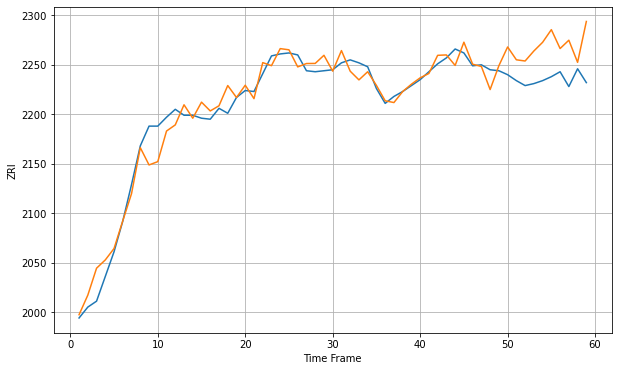

Wall time: 9.34 s
11369 13.192850328704935 33.83841688134347


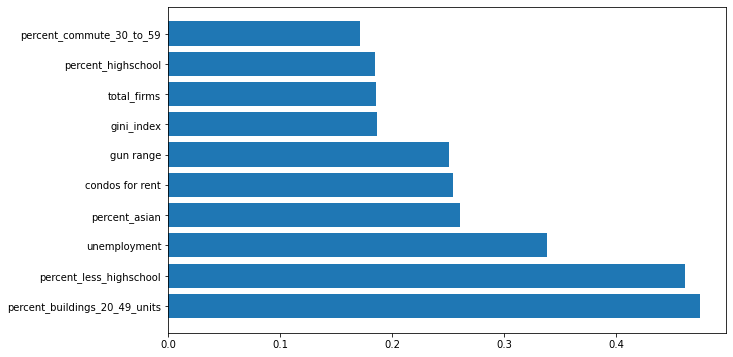


Got an mse at 0.0025 in epoch 126 and stopped training



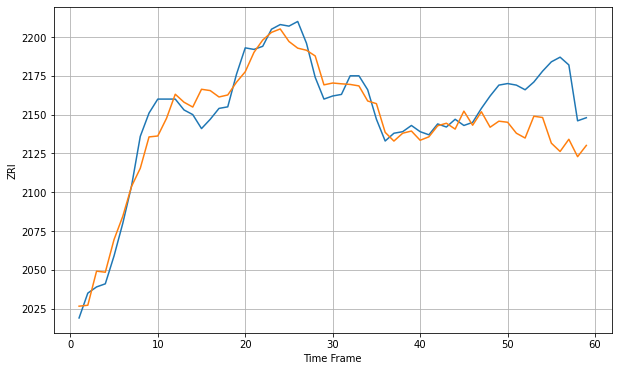

Wall time: 11 s
11370 9.79610254834373 34.706125657293946


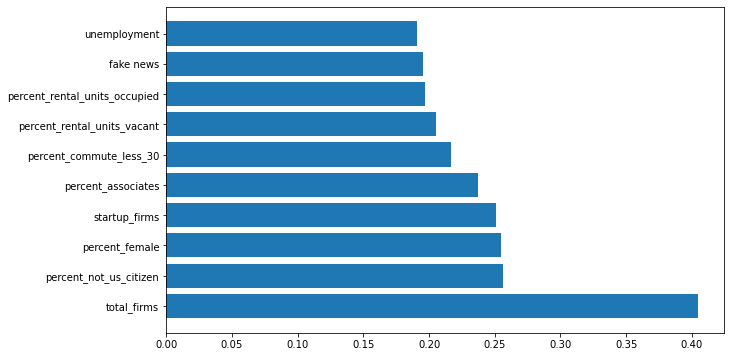


Got an mse at 0.0024 in epoch 83 and stopped training



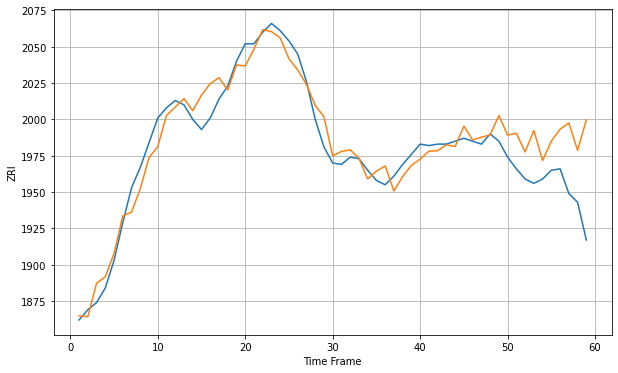

Wall time: 9.91 s
11372 10.0121489201821 34.863595118954805


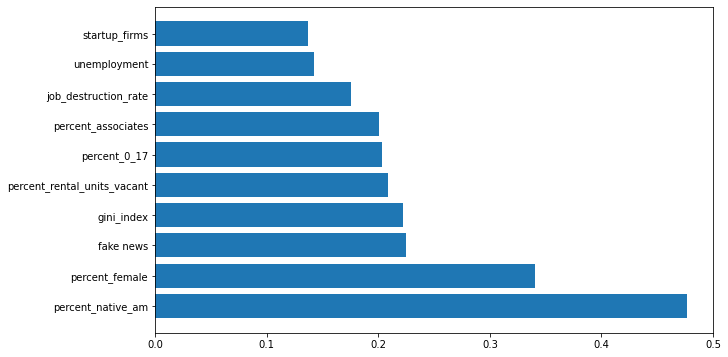


Got an mse at 0.0025 in epoch 123 and stopped training



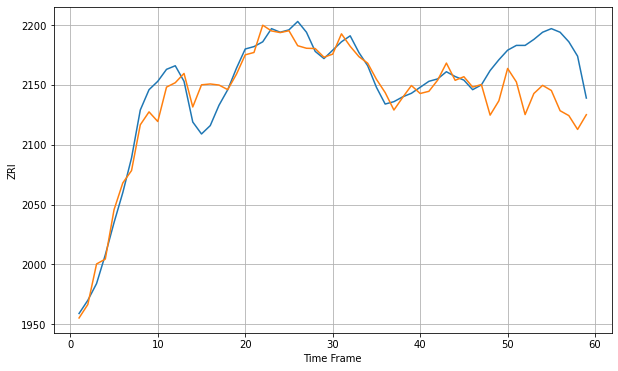

Wall time: 11.2 s
11373 12.582760695575022 46.35911572058793


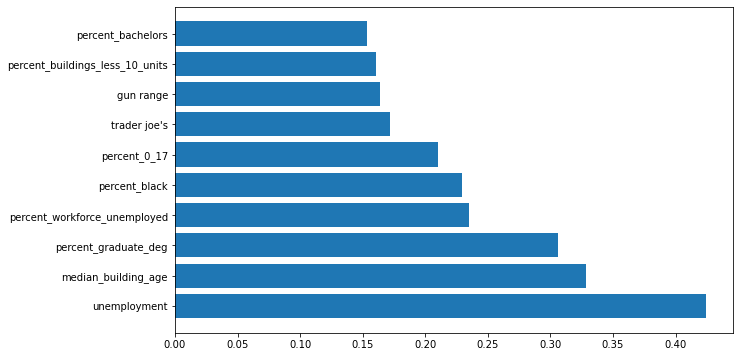


Got an mse at 0.0025 in epoch 95 and stopped training



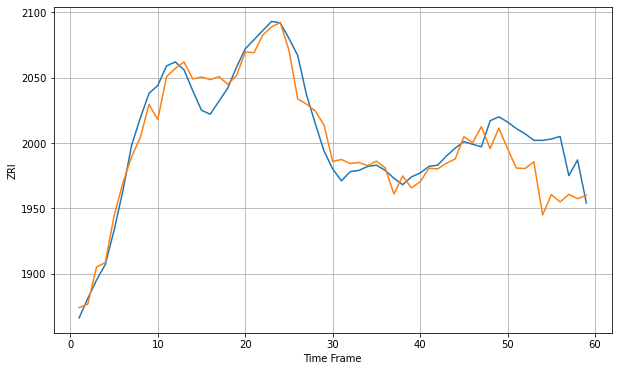

Wall time: 10.2 s
11374 11.56246689097624 31.036805685003134


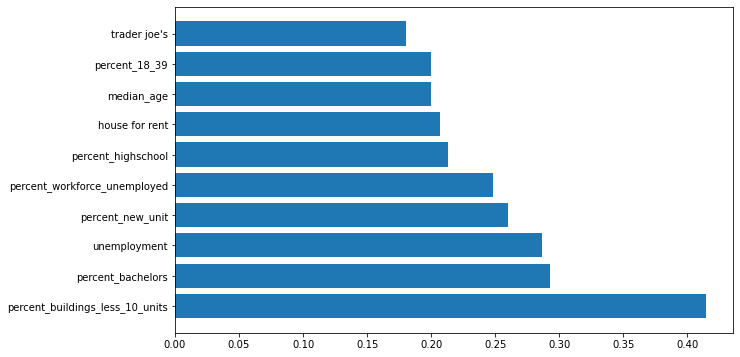


Got an mse at 0.0025 in epoch 113 and stopped training



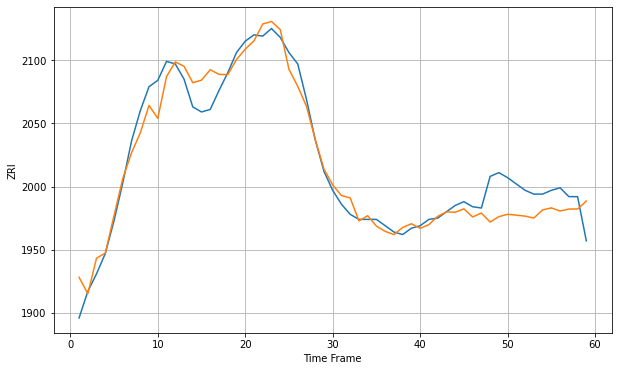

Wall time: 10.7 s
11375 11.687865806053592 23.478101300141986


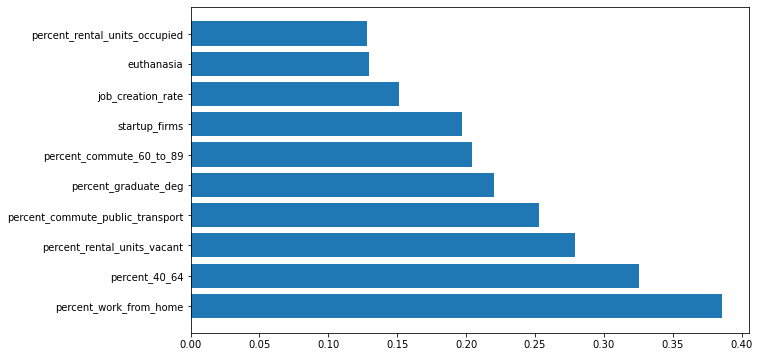


Got an mse at 0.0025 in epoch 152 and stopped training



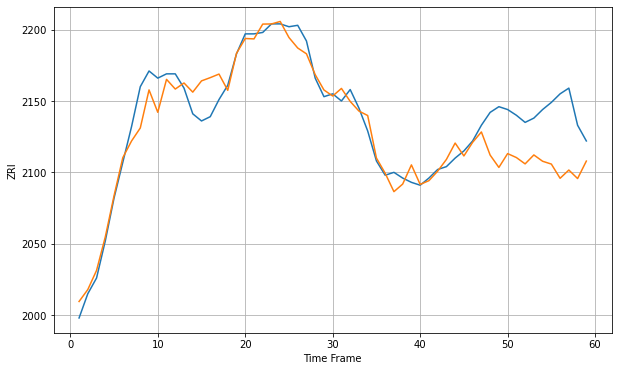

Wall time: 11.7 s
11377 10.71504731193353 38.30560121880431


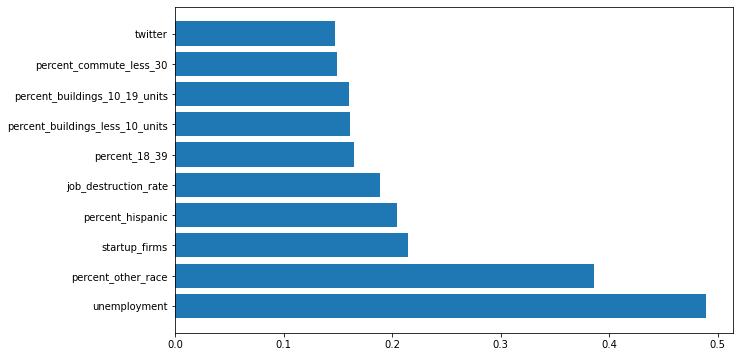


Got an mse at 0.0025 in epoch 140 and stopped training



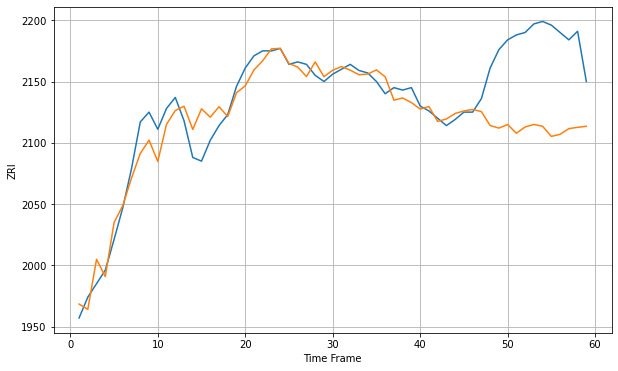

Wall time: 11.9 s
11378 12.771100188648866 73.82431465986527


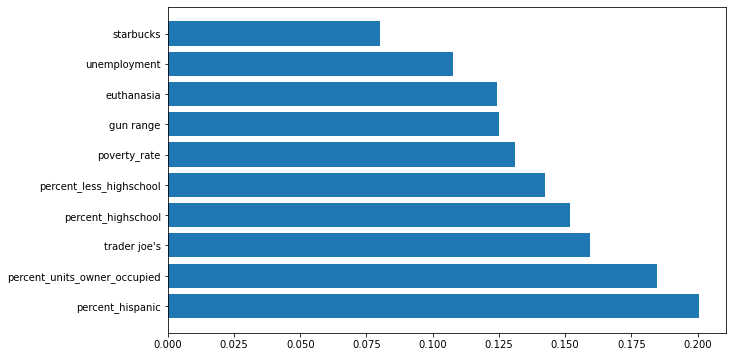


Got an mse at 0.0025 in epoch 103 and stopped training



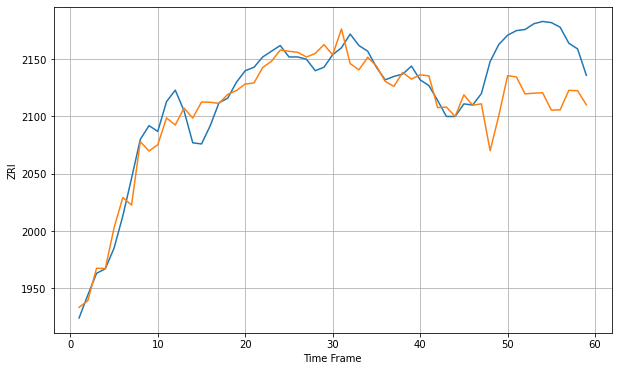

Wall time: 10.7 s
11379 13.40450567932648 56.483070019606984


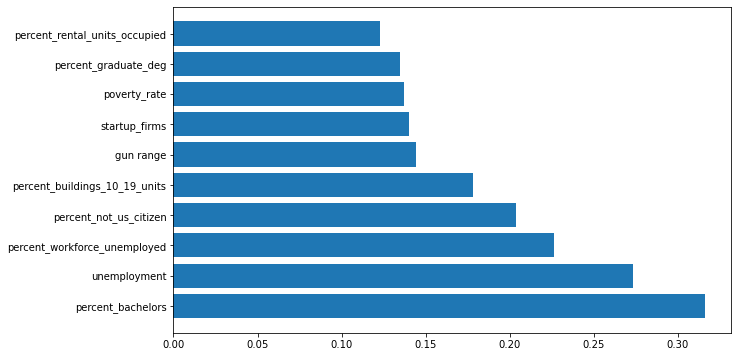


Got an mse at 0.0025 in epoch 82 and stopped training



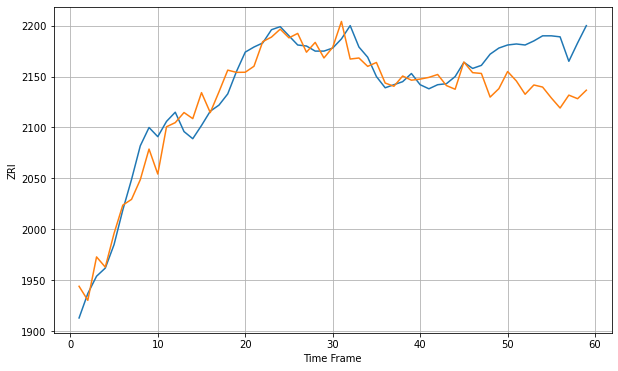

Wall time: 9.79 s
11385 15.206753988437063 49.00850147496549


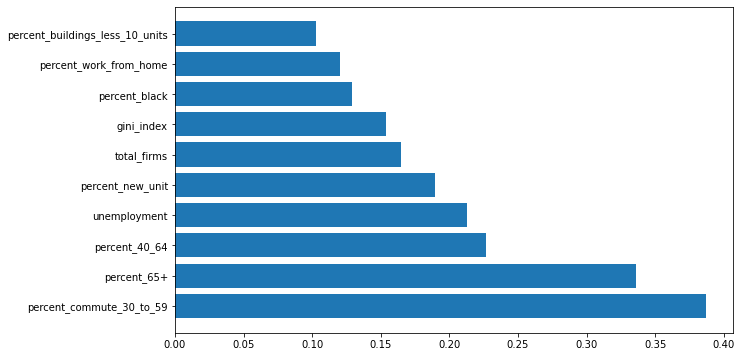


Got an mse at 0.0025 in epoch 47 and stopped training



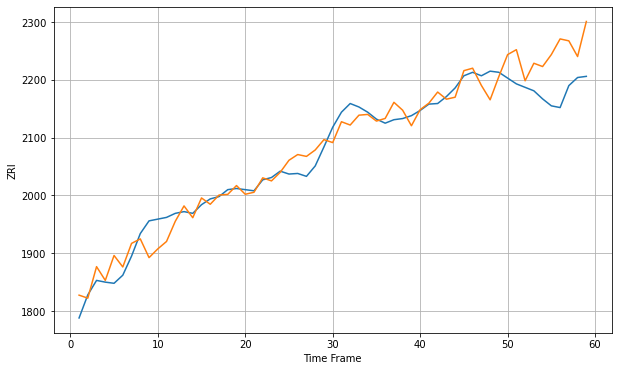

Wall time: 9.07 s
11412 22.302756766035184 65.51037840717925


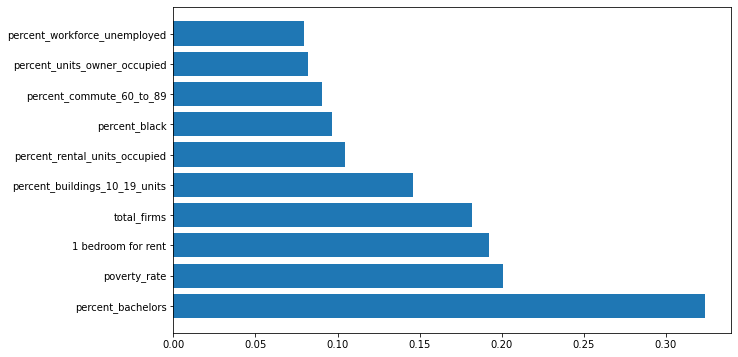


Got an mse at 0.0025 in epoch 40 and stopped training



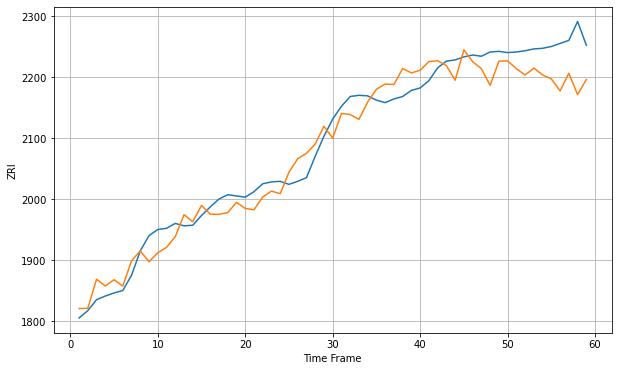

Wall time: 8.91 s
11413 24.570554389174934 56.246614958308896


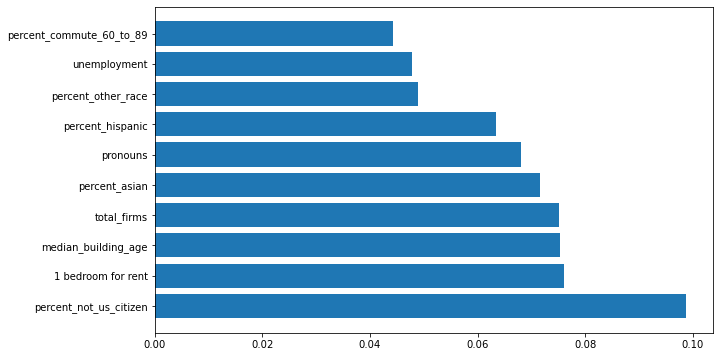


Got an mse at 0.0025 in epoch 39 and stopped training



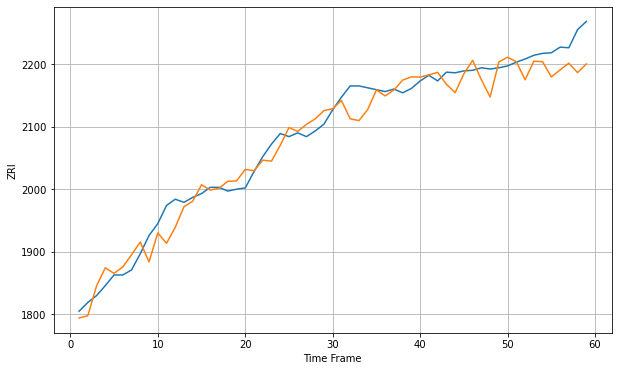

Wall time: 8.9 s
11414 22.906422345771613 36.94168241538863


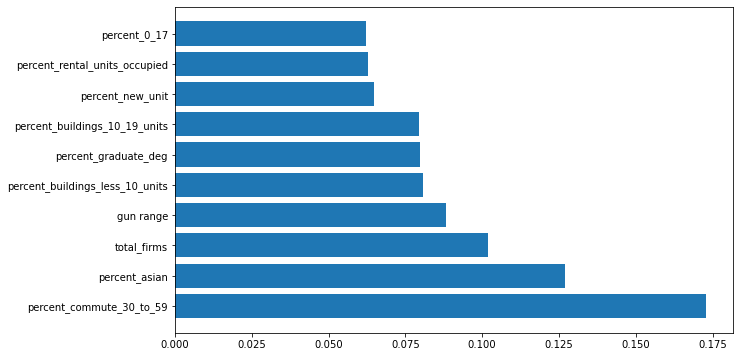


Got an mse at 0.0025 in epoch 55 and stopped training



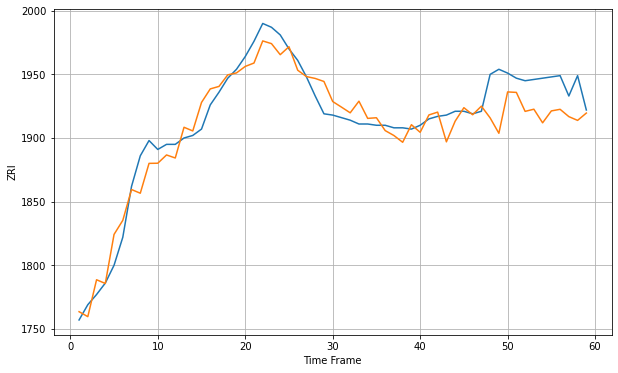

Wall time: 9.27 s
11415 11.713611969517087 27.866290553432897


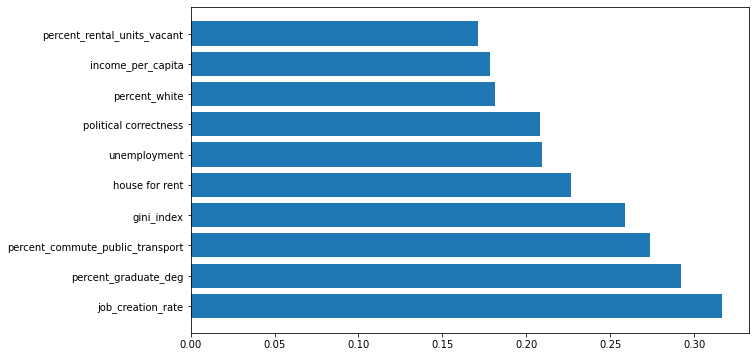


Got an mse at 0.0025 in epoch 30 and stopped training



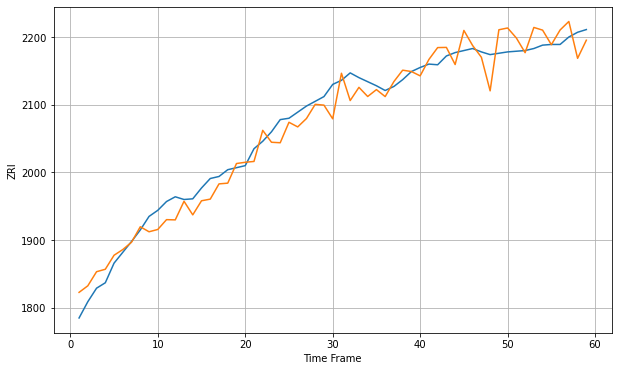

Wall time: 8.58 s
11416 20.373041785046563 28.692859045954503


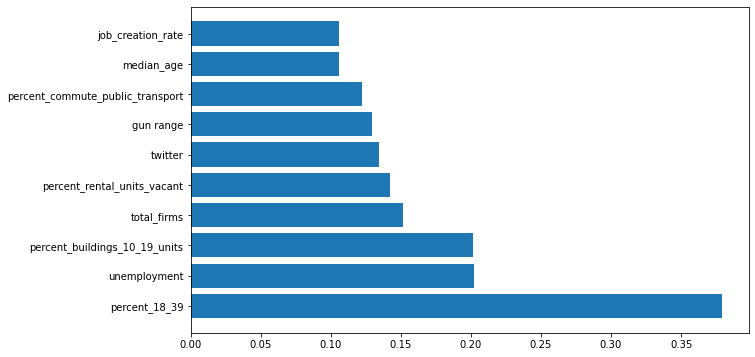


Got an mse at 0.0024 in epoch 37 and stopped training



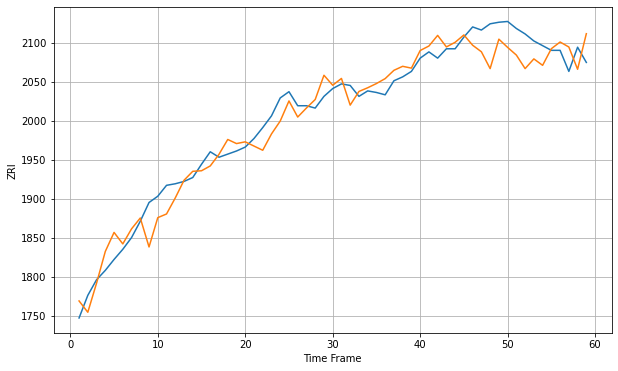

Wall time: 8.72 s
11417 19.16275836251032 32.17176630882702


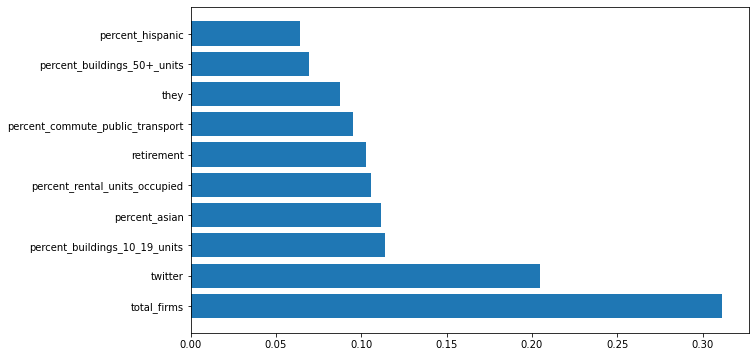


Got an mse at 0.0025 in epoch 39 and stopped training



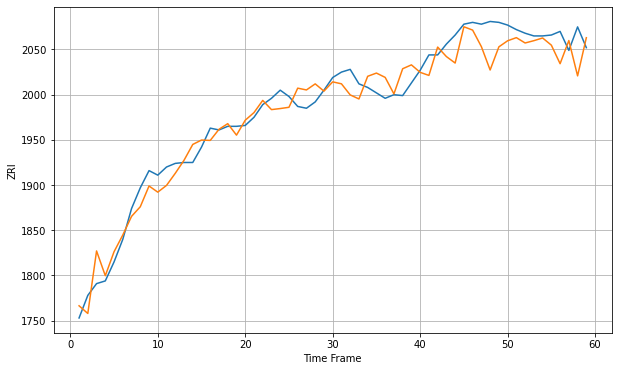

Wall time: 8.67 s
11418 16.43461018164099 26.96136488601563


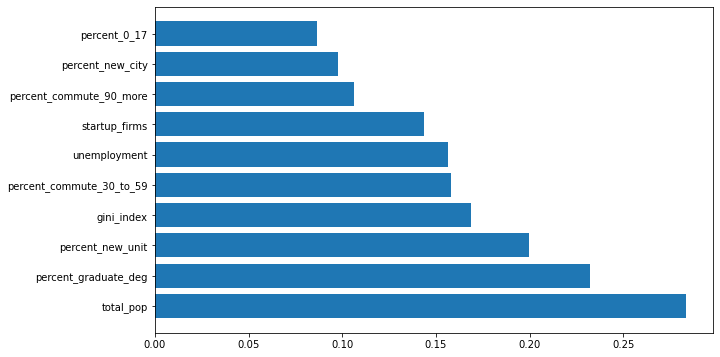


Got an mse at 0.0024 in epoch 26 and stopped training



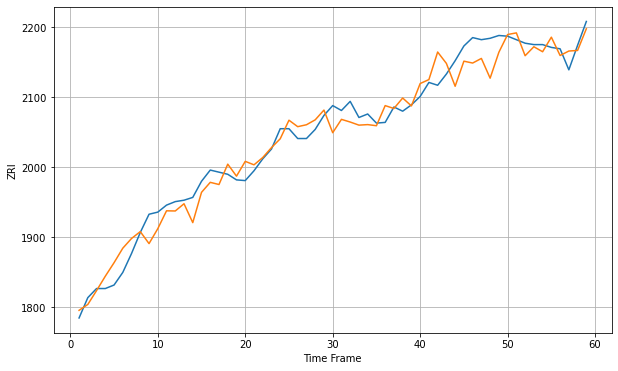

Wall time: 8.65 s
11419 21.02080079475221 21.46904518417109


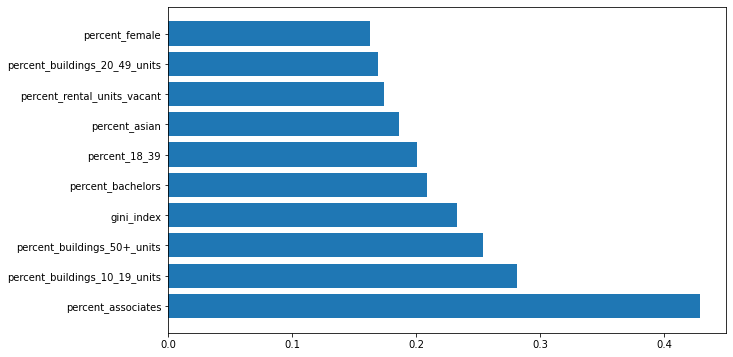


Got an mse at 0.0025 in epoch 35 and stopped training



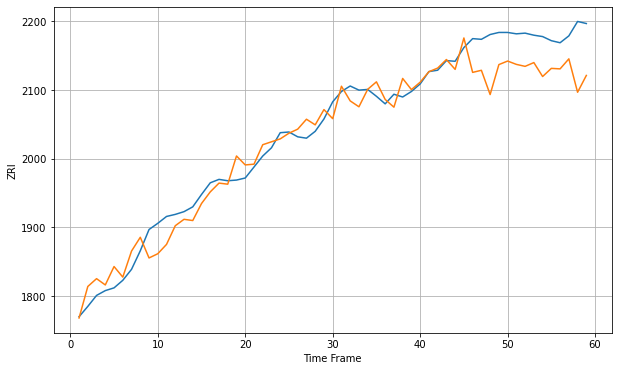

Wall time: 8.56 s
11420 21.35517234775008 58.74600146825938


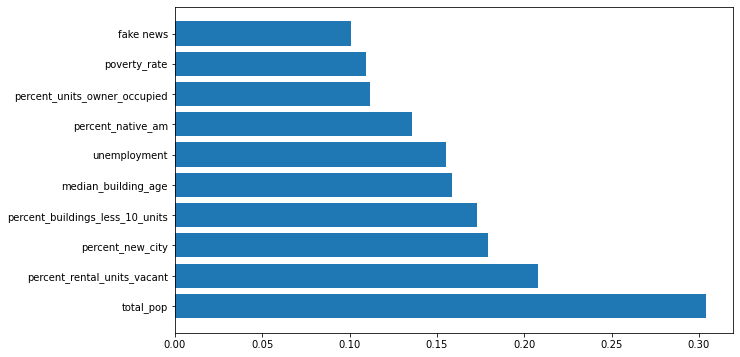


Got an mse at 0.0024 in epoch 62 and stopped training



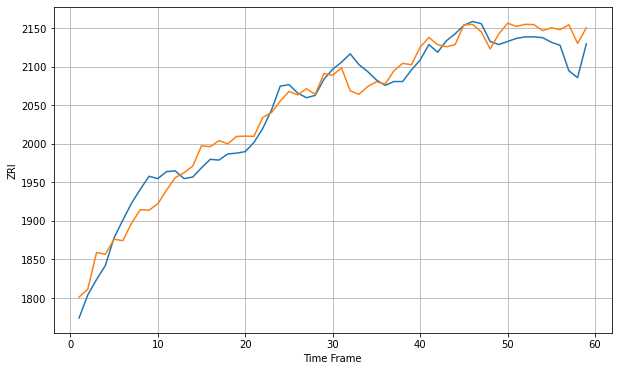

Wall time: 9.35 s
11421 19.508713724414147 26.525693901264177


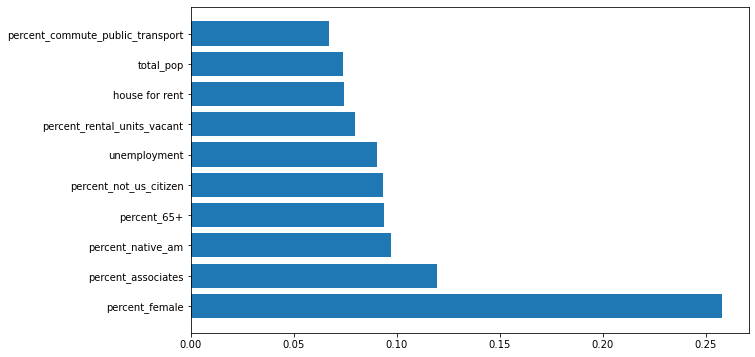


Got an mse at 0.0024 in epoch 53 and stopped training



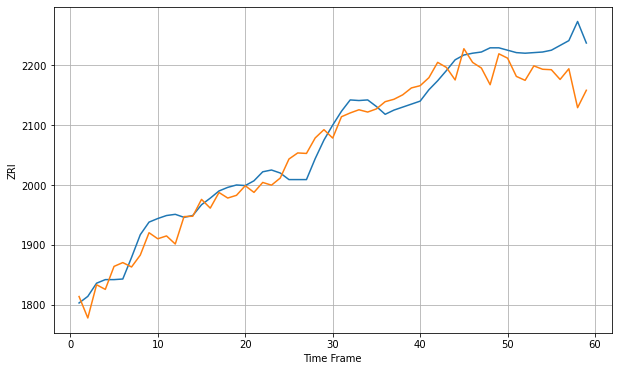

Wall time: 9.15 s
11422 23.61034652043893 59.48229115644488


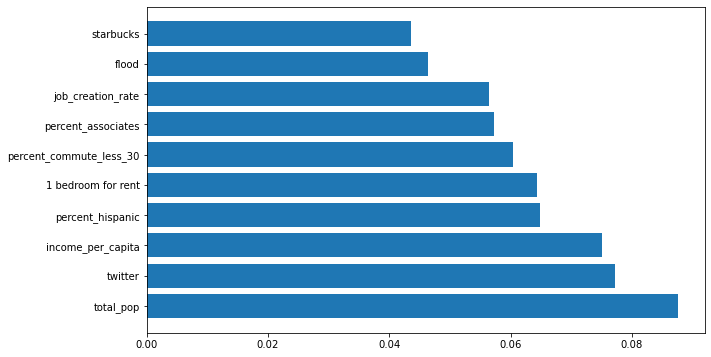


Got an mse at 0.0025 in epoch 51 and stopped training



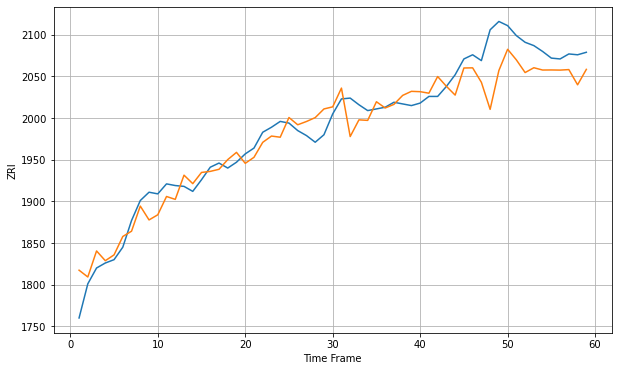

Wall time: 9.06 s
11423 18.40155530476028 40.02959822086312


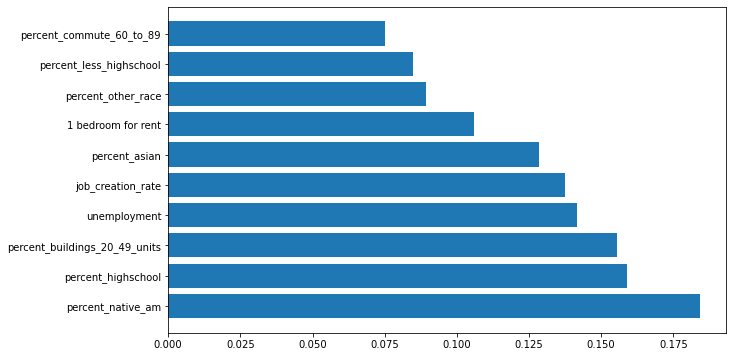


Got an mse at 0.0024 in epoch 43 and stopped training



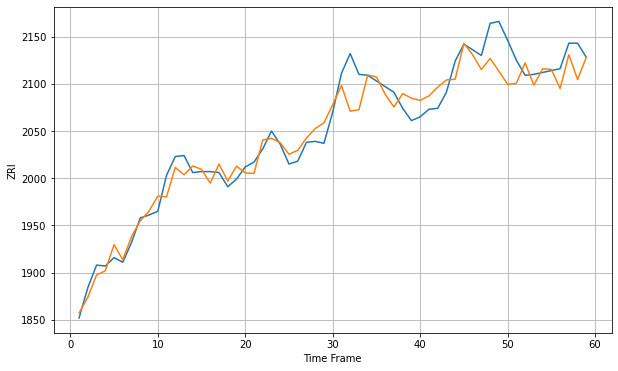

Wall time: 9.03 s
11426 15.90469404184633 27.855976473089367


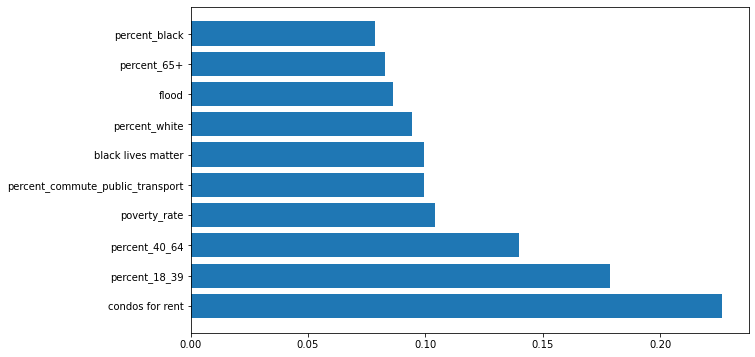


Got an mse at 0.0025 in epoch 88 and stopped training



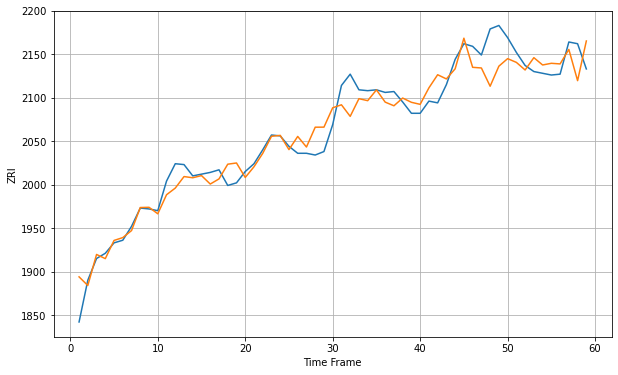

Wall time: 10.1 s
11427 17.40476079389466 30.07463700764834


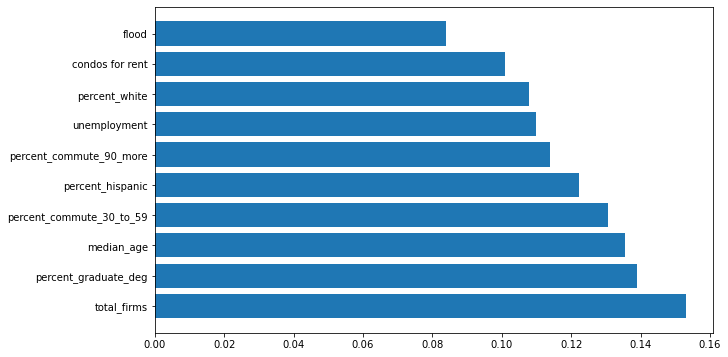


Got an mse at 0.0025 in epoch 75 and stopped training



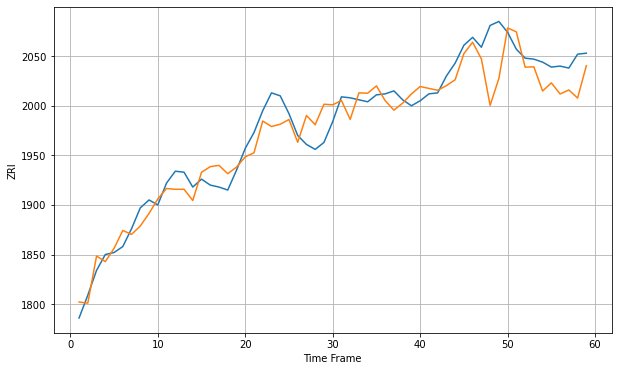

Wall time: 10.1 s
11428 15.616620429094416 35.08472373738069


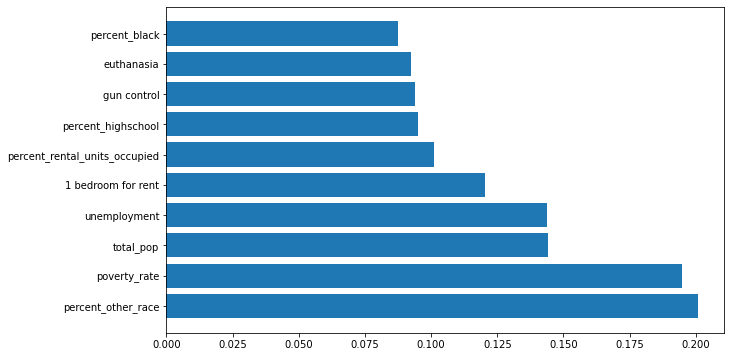


Got an mse at 0.0024 in epoch 42 and stopped training



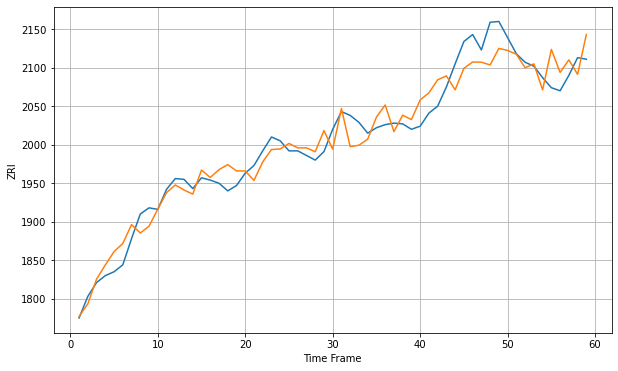

Wall time: 8.73 s
11429 20.215461218607604 28.62728240817058


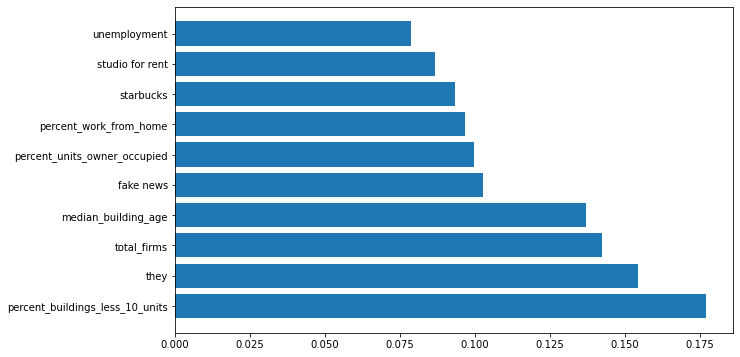


Got an mse at 0.0025 in epoch 50 and stopped training



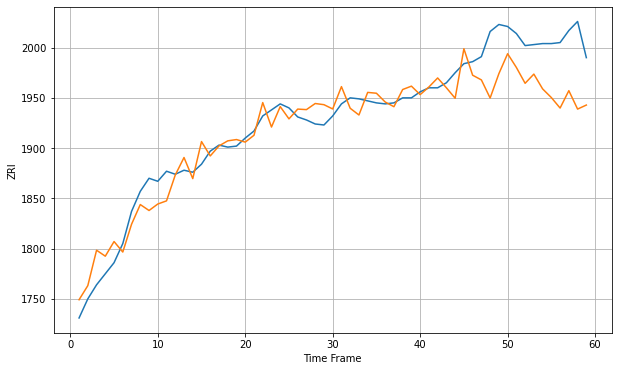

Wall time: 9.03 s
11432 14.93704543456423 52.82226310126944


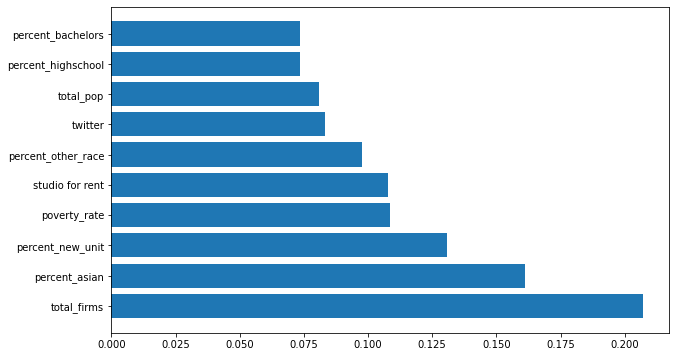


Got an mse at 0.0024 in epoch 39 and stopped training



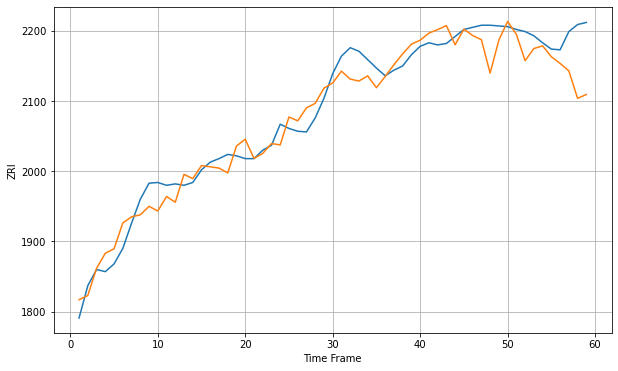

Wall time: 8.83 s
11433 21.33095542341032 51.97714985845128


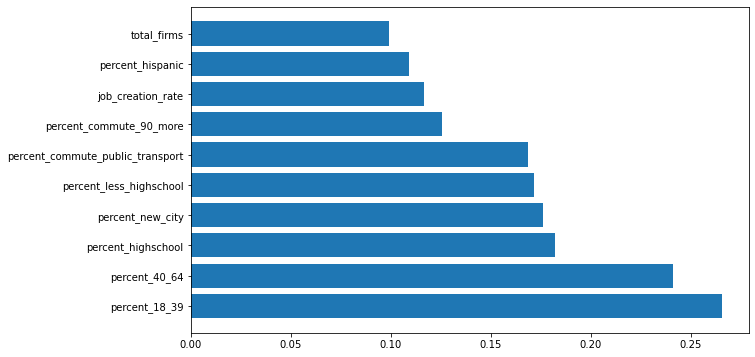


Got an mse at 0.0024 in epoch 42 and stopped training



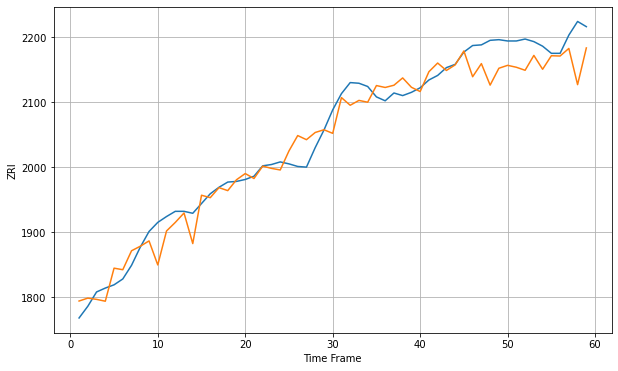

Wall time: 8.97 s
11434 23.081698880608222 45.36888137405474


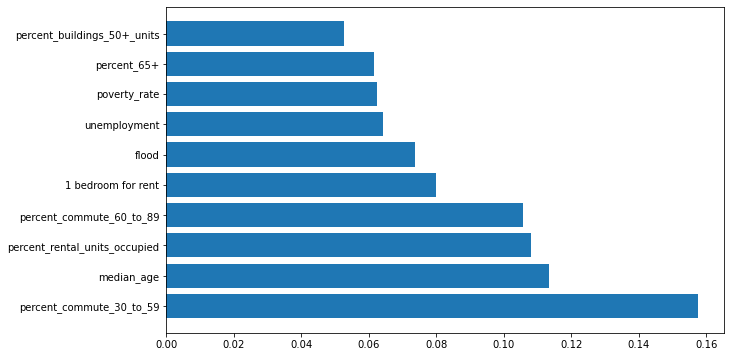


Got an mse at 0.0025 in epoch 38 and stopped training



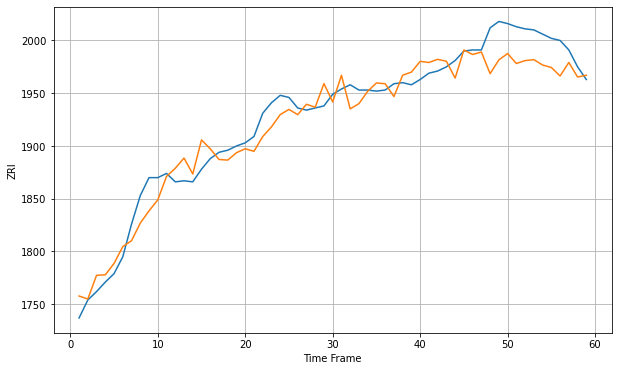

Wall time: 8.89 s
11435 14.154895064754076 28.774899451747064


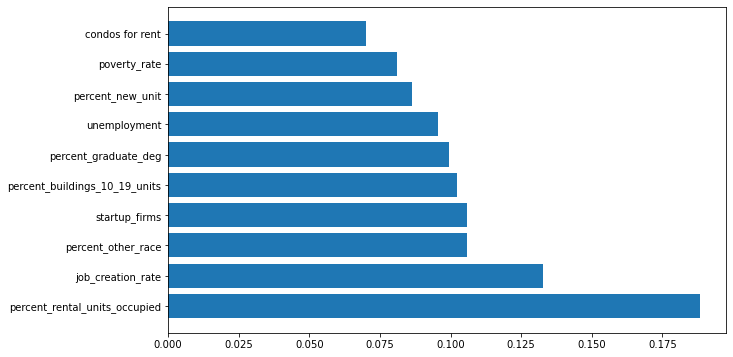


Got an mse at 0.0025 in epoch 50 and stopped training



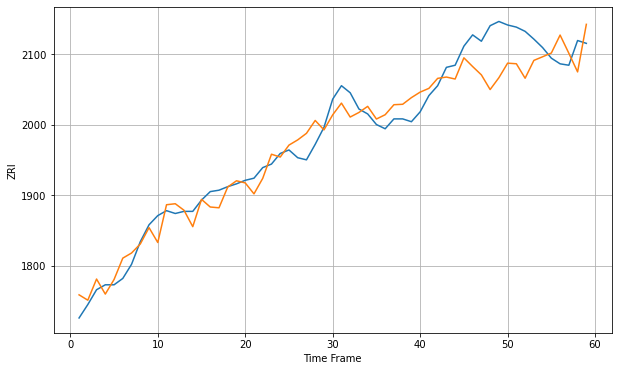

Wall time: 9.08 s
11436 21.23325855976671 50.28600453984028


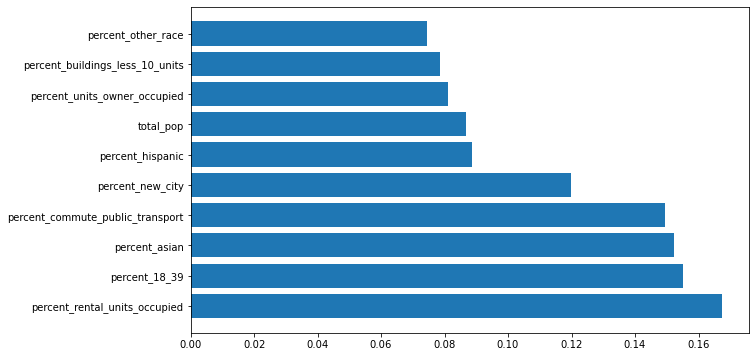


Got an mse at 0.0025 in epoch 132 and stopped training



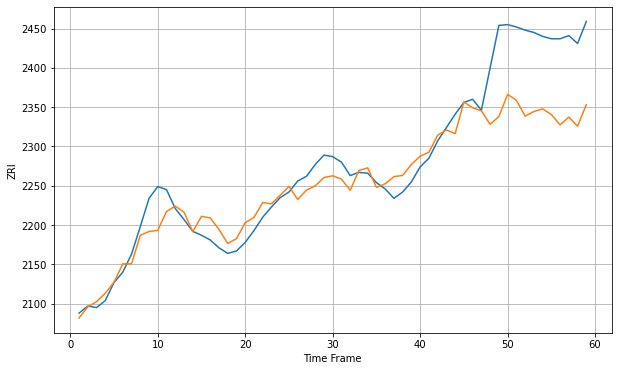

Wall time: 11.4 s
11542 18.820706736134614 100.03221757078563


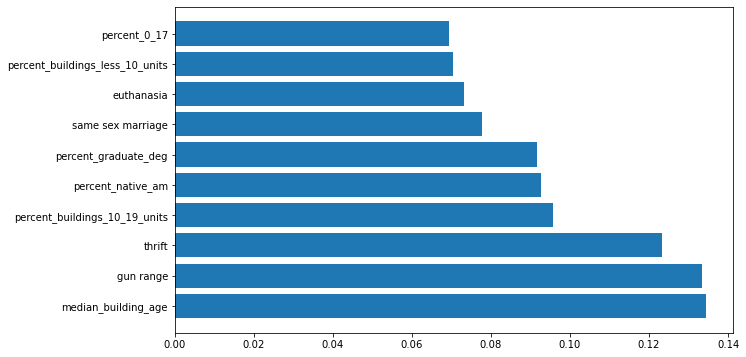


Got an mse at 0.0025 in epoch 64 and stopped training



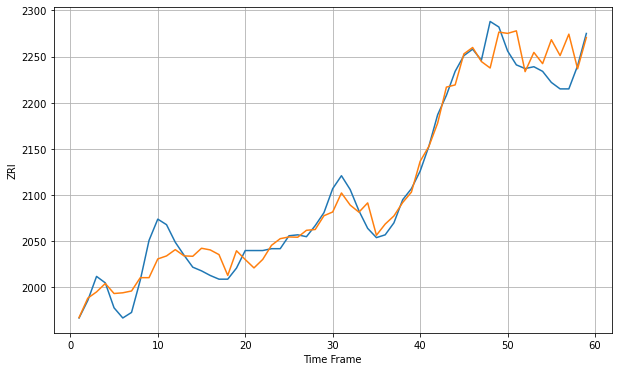

Wall time: 10.4 s
11550 16.37327130422993 31.082040957735018


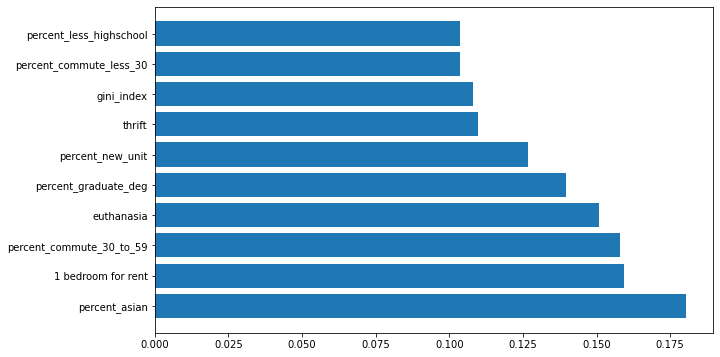


Got an mse at 0.0025 in epoch 36 and stopped training



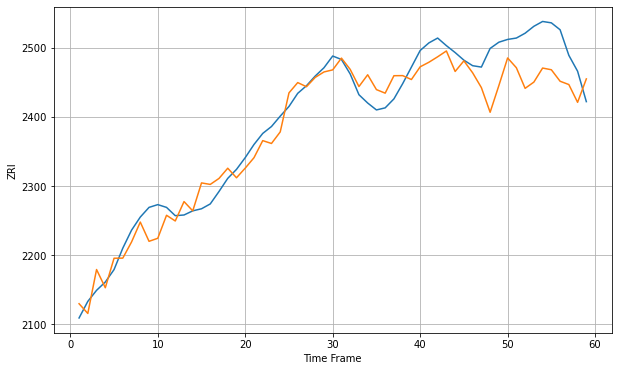

Wall time: 9.61 s
11561 21.792938105796775 62.91745025280561


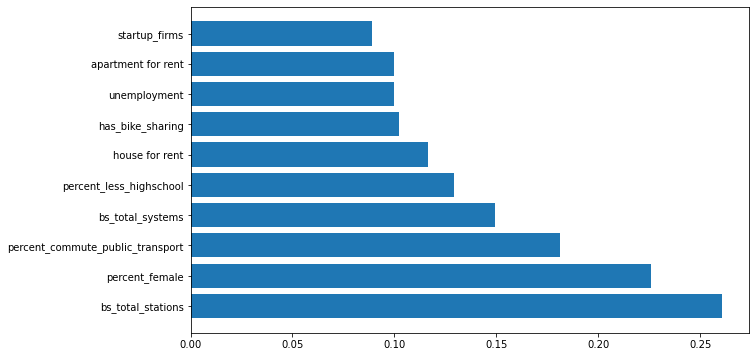


Got an mse at 0.0025 in epoch 91 and stopped training



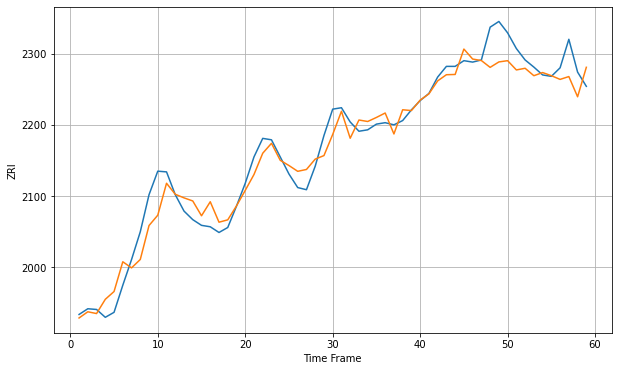

Wall time: 11.3 s
11563 20.61608895817834 34.19255907471275


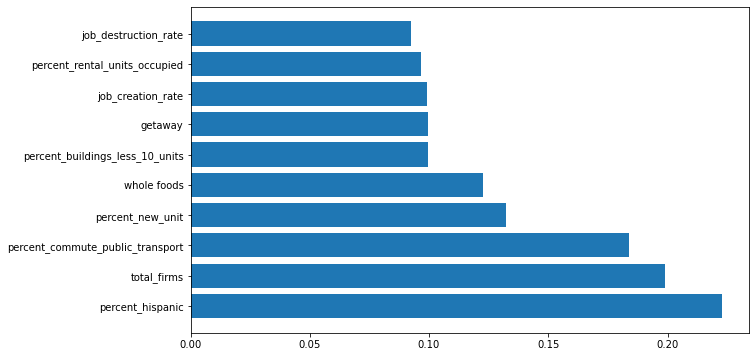


Got an mse at 0.0025 in epoch 172 and stopped training



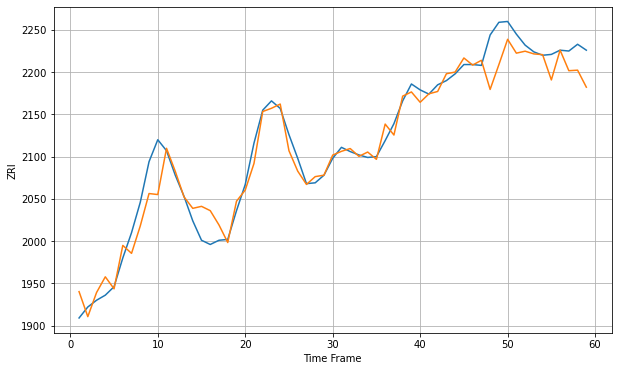

Wall time: 13 s
11580 18.122509145025905 31.61129763663292


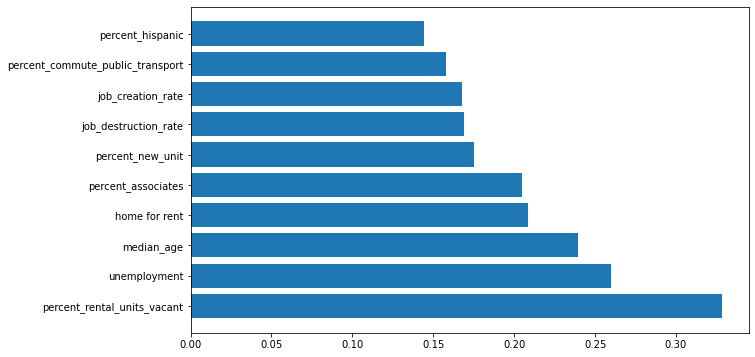


Got an mse at 0.0025 in epoch 64 and stopped training



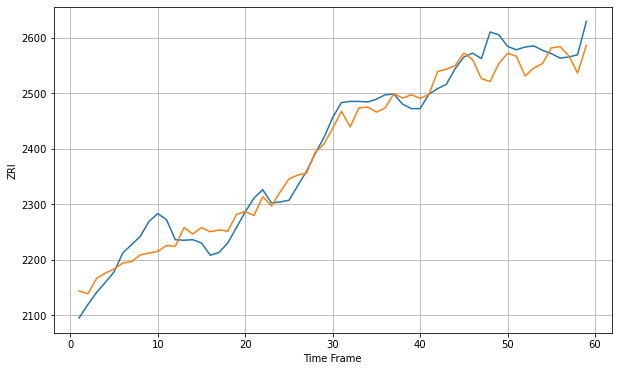

Wall time: 10.4 s
11590 26.88848706824414 40.05224274912018


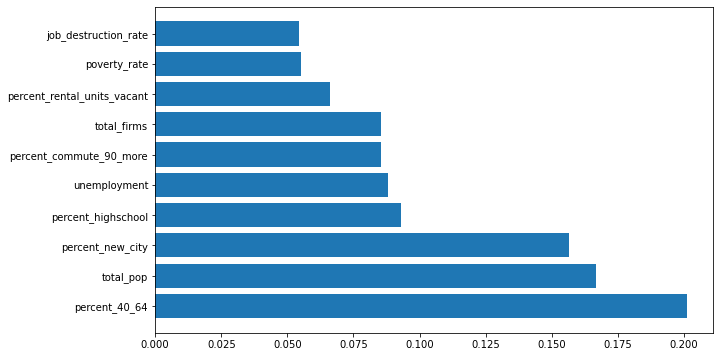


Got an mse at 0.0025 in epoch 51 and stopped training



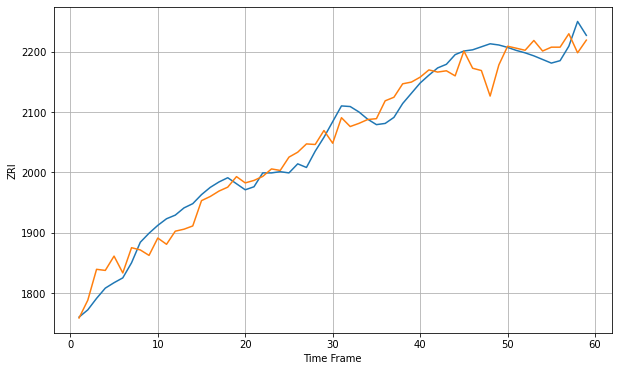

Wall time: 9.55 s
11691 24.5950148993925 33.98468958027529


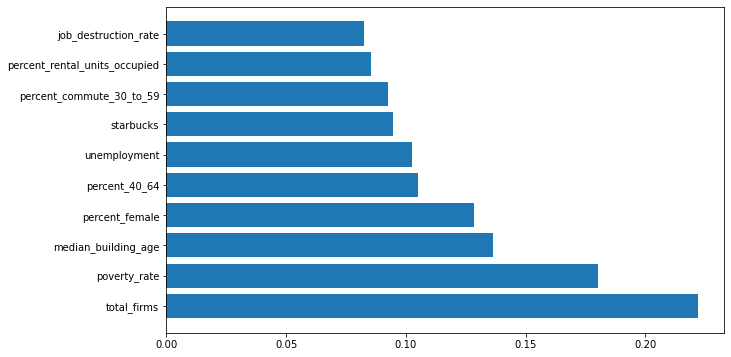


Got an mse at 0.0024 in epoch 37 and stopped training



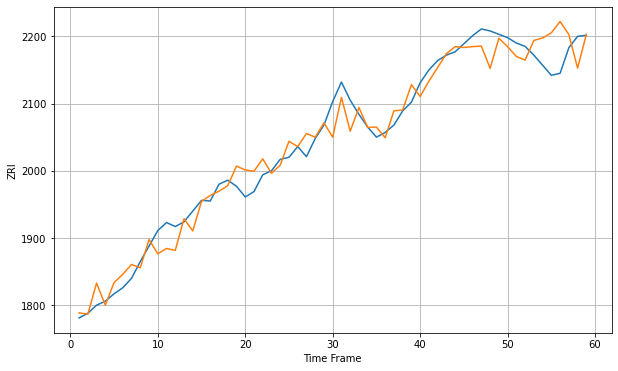

Wall time: 9.43 s
11692 21.725296669127708 39.60727034992104


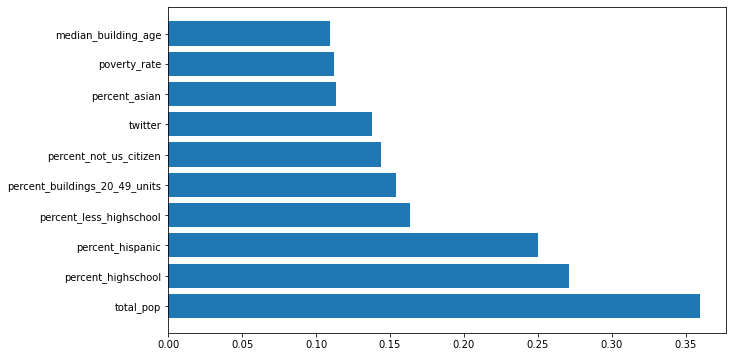


Got an mse at 0.0024 in epoch 45 and stopped training



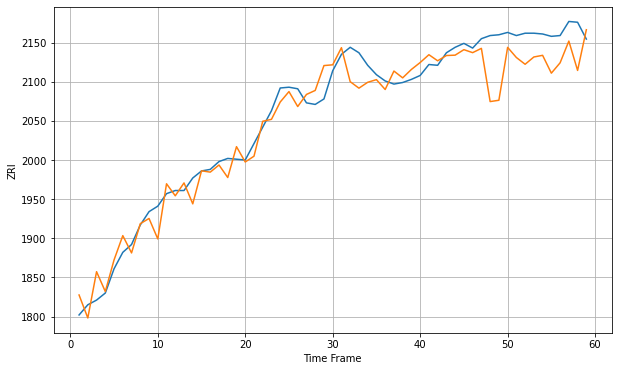

Wall time: 9.12 s
11694 18.830314182353998 46.992054466406614


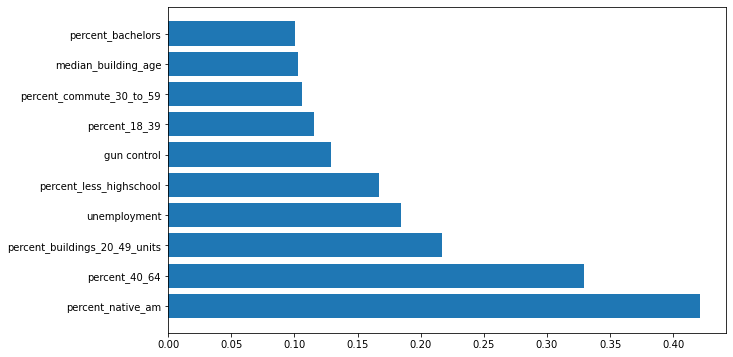


Got an mse at 0.0025 in epoch 175 and stopped training



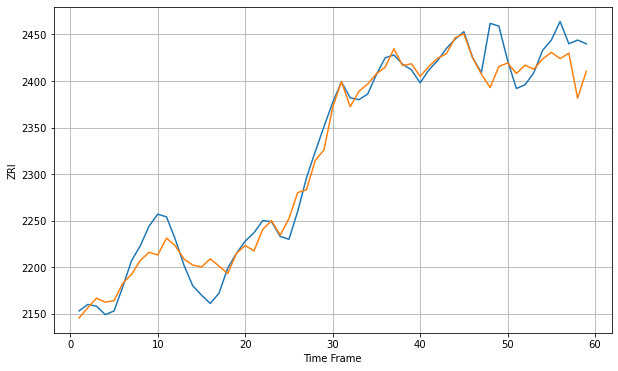

Wall time: 13.1 s
11758 15.811316718391494 34.24841051216373


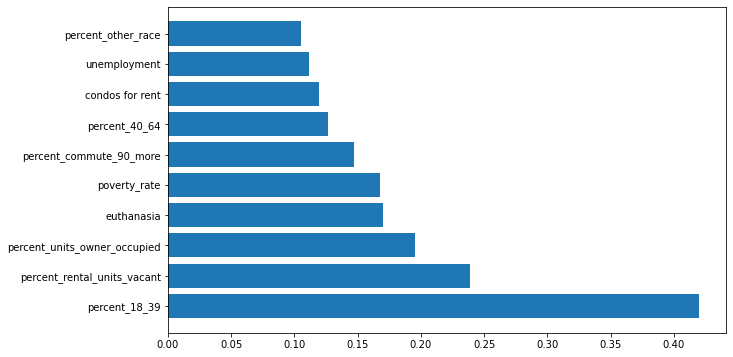


Got an mse at 0.0025 in epoch 129 and stopped training



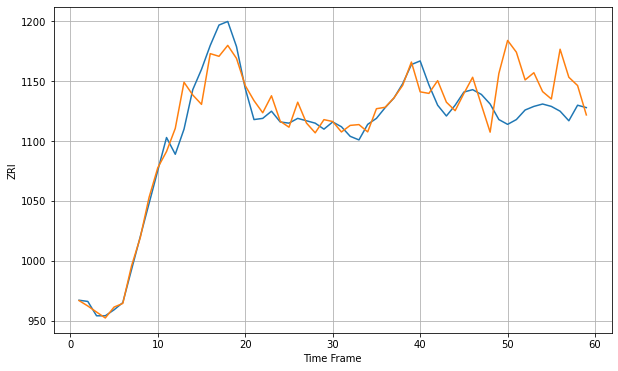

Wall time: 11.6 s
12047 12.155277090077714 36.53428820868609


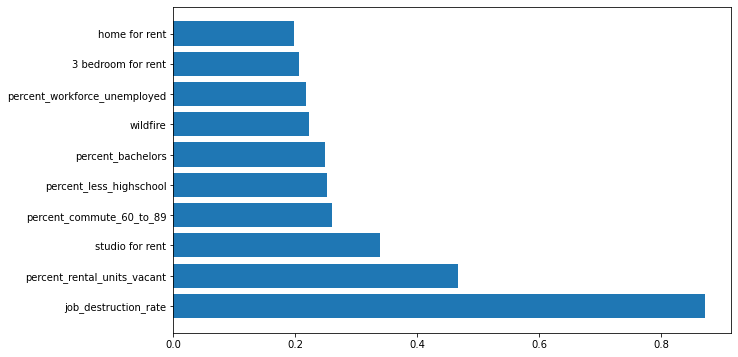


Got an mse at 0.0025 in epoch 116 and stopped training



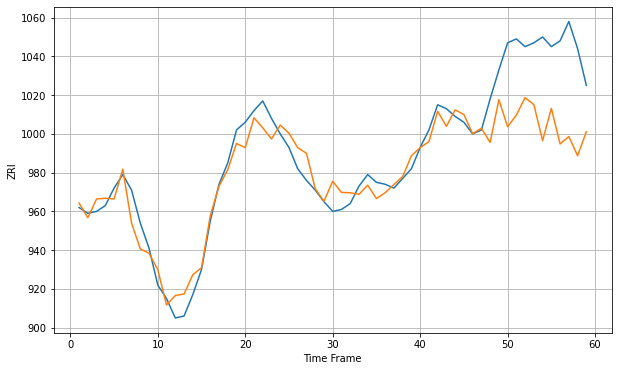

Wall time: 11.1 s
12180 7.532097109203528 40.540960093001225


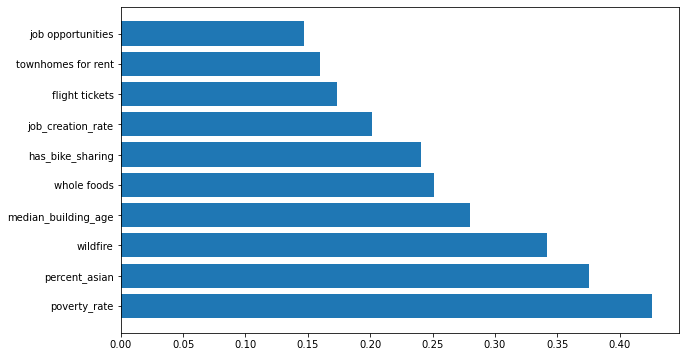


Got an mse at 0.0025 in epoch 80 and stopped training



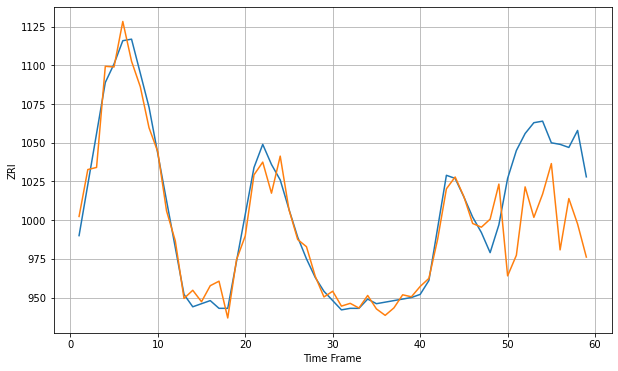

Wall time: 10.2 s
12182 8.564085862320521 49.28122910620491


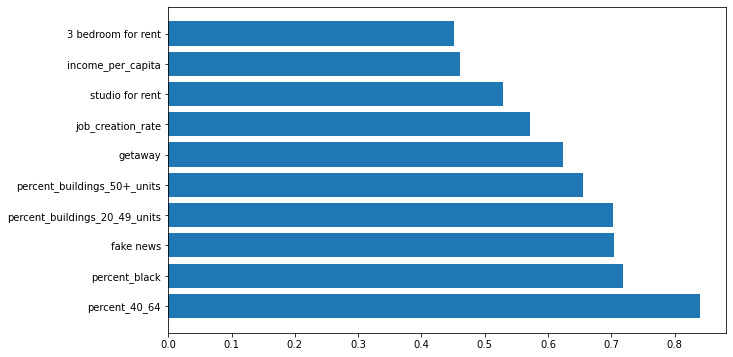


Got an mse at 0.0025 in epoch 84 and stopped training



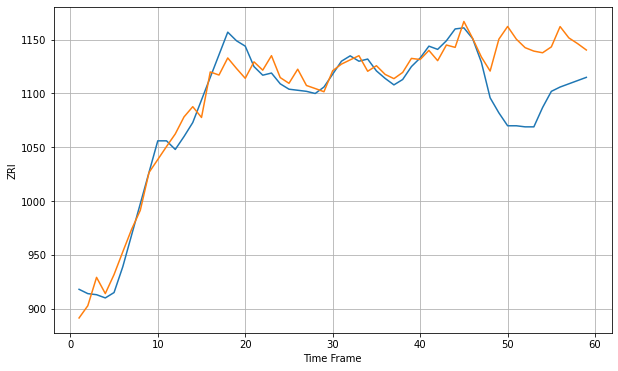

Wall time: 10.4 s
12189 12.36533381298265 58.99847168957091


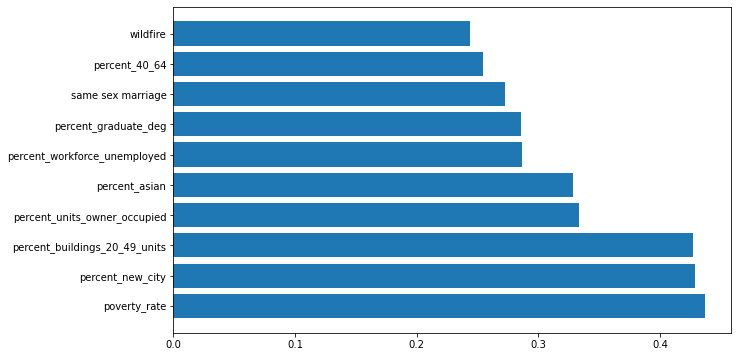


Got an mse at 0.0025 in epoch 148 and stopped training



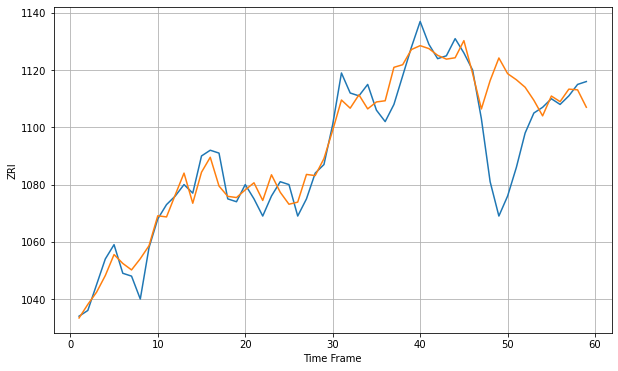

Wall time: 12.6 s
12202 5.399953083066162 24.90603580783011


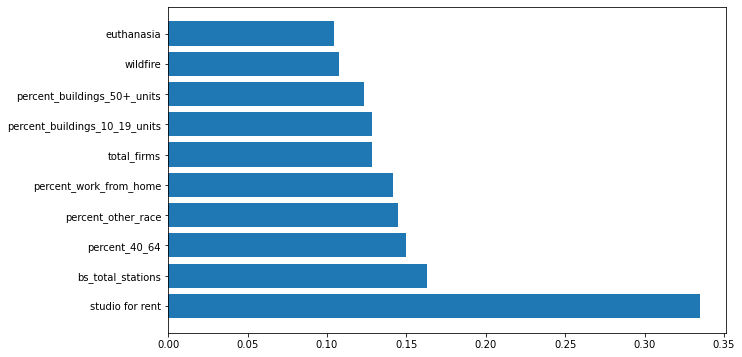


Got an mse at 0.0025 in epoch 119 and stopped training



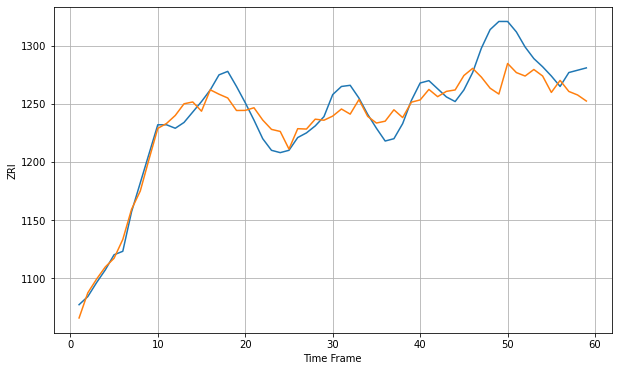

Wall time: 11.4 s
12203 12.056746564043065 31.008295275228562


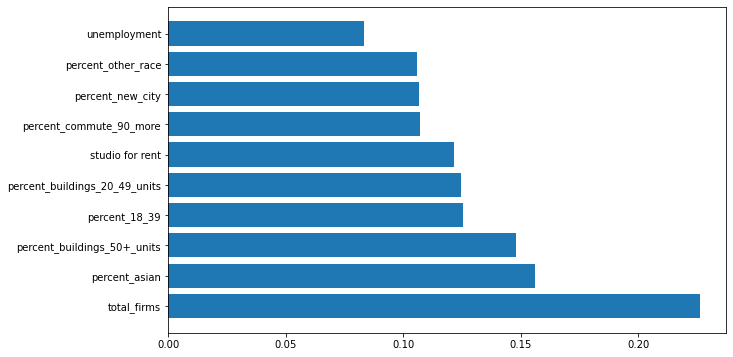


Got an mse at 0.0025 in epoch 125 and stopped training



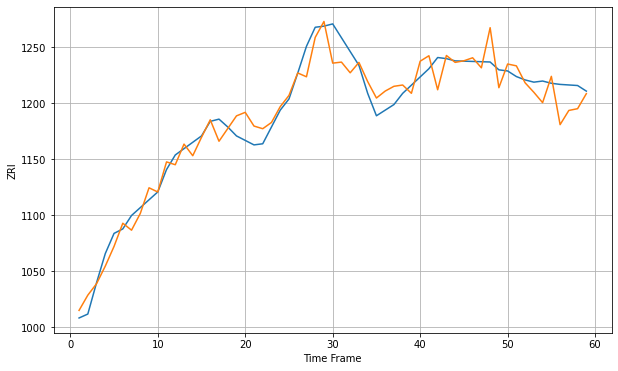

Wall time: 12.1 s
12206 13.207269330683108 18.400332220045694


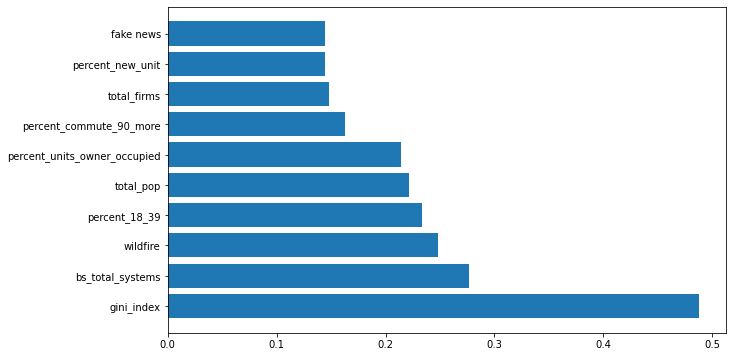


Got an mse at 0.0025 in epoch 133 and stopped training



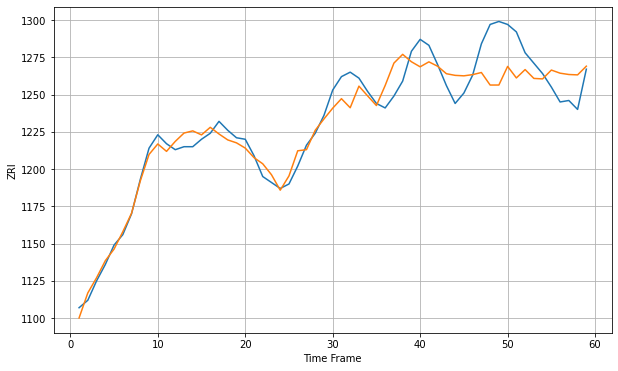

Wall time: 12.4 s
12208 9.556407662182657 23.815129727241803


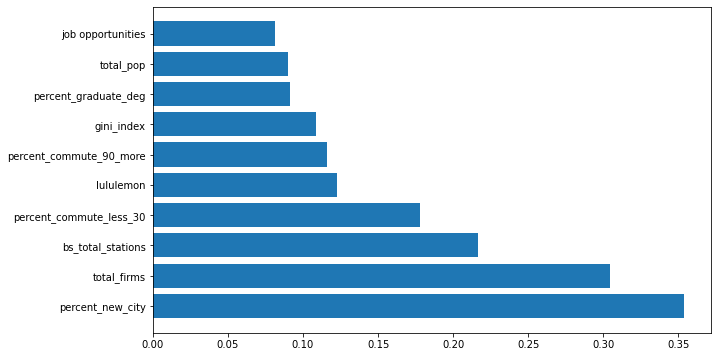


Got an mse at 0.0025 in epoch 105 and stopped training



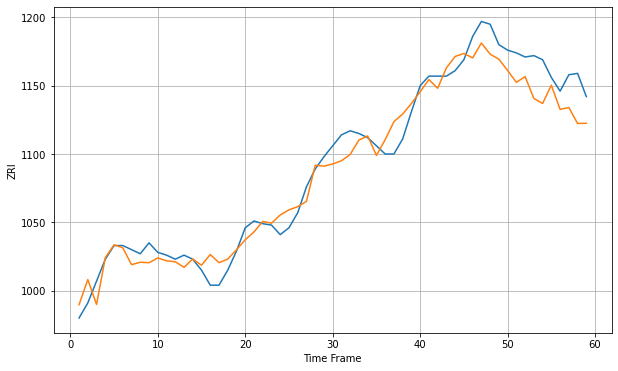

Wall time: 11 s
12209 10.774278751342871 22.36403376336449


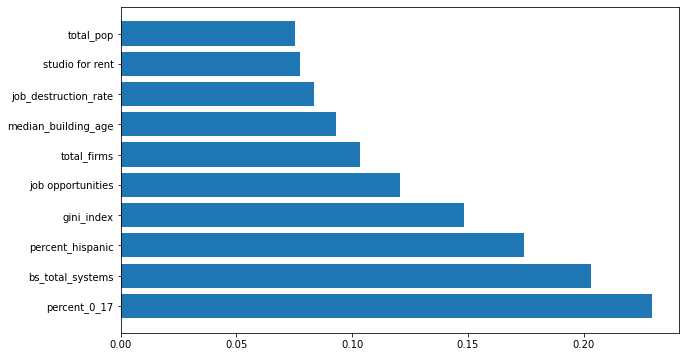


Got an mse at 0.0025 in epoch 97 and stopped training



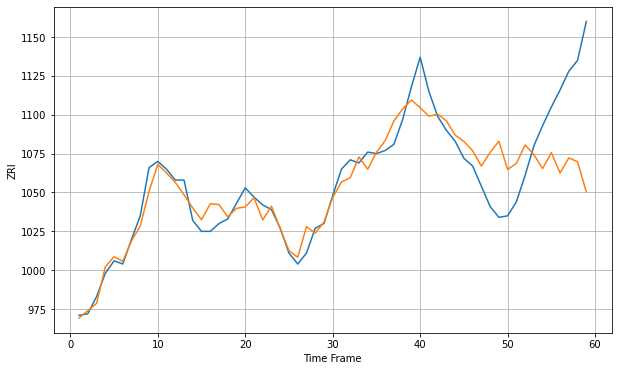

Wall time: 11.3 s
12210 9.309292341172855 49.50596029347662


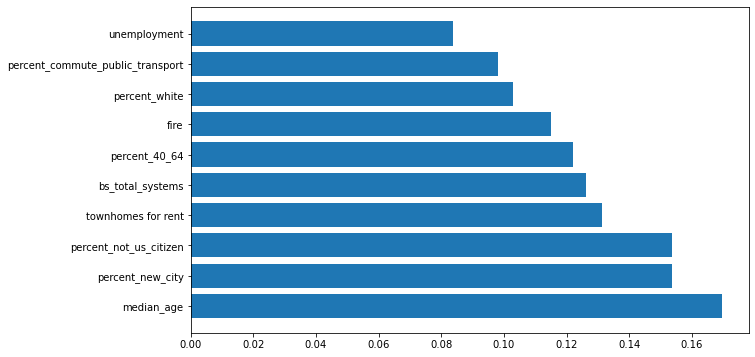


Got an mse at 0.0025 in epoch 59 and stopped training



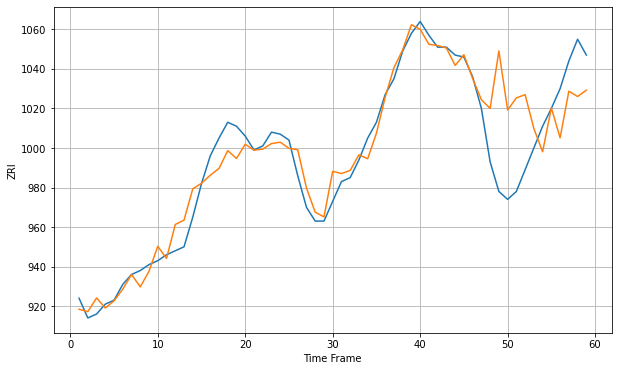

Wall time: 9.69 s
12303 7.360876379746711 33.889638352167154


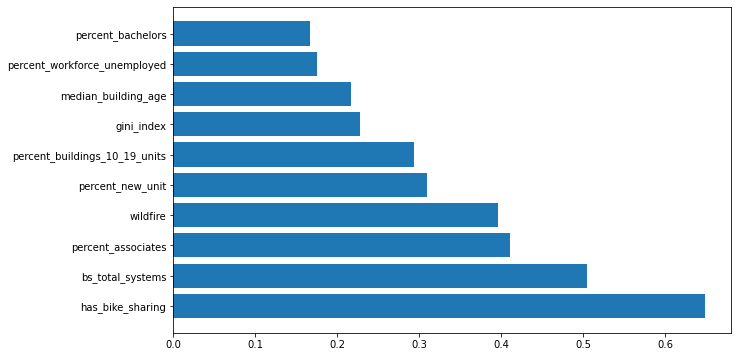


Got an mse at 0.0024 in epoch 168 and stopped training



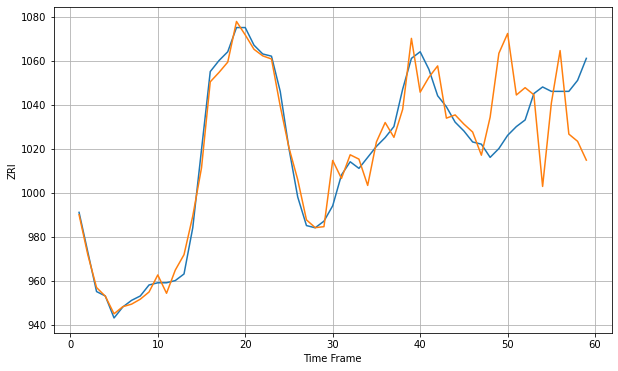

Wall time: 12.6 s
12304 6.4584188938022535 29.544573107801366


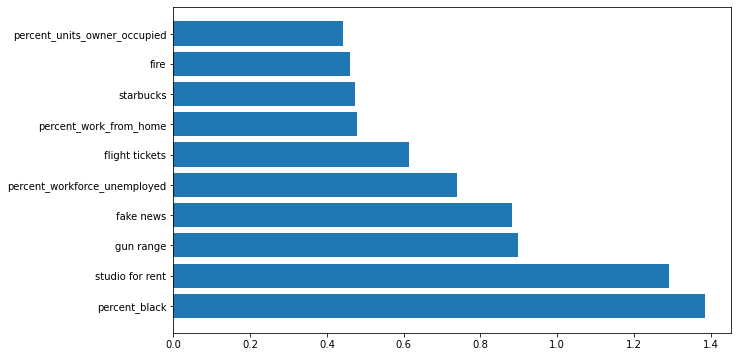


Got an mse at 0.0025 in epoch 108 and stopped training



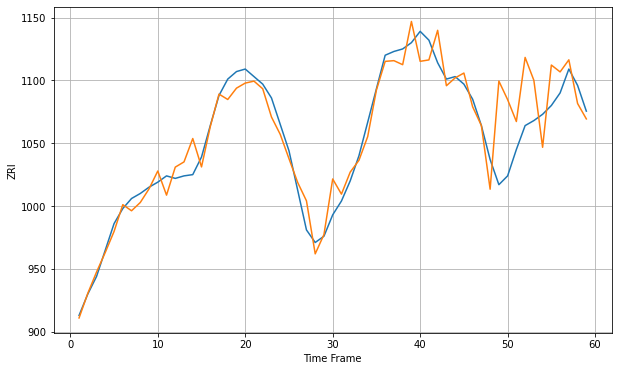

Wall time: 11.6 s
12306 11.656611187763774 38.517534973697494


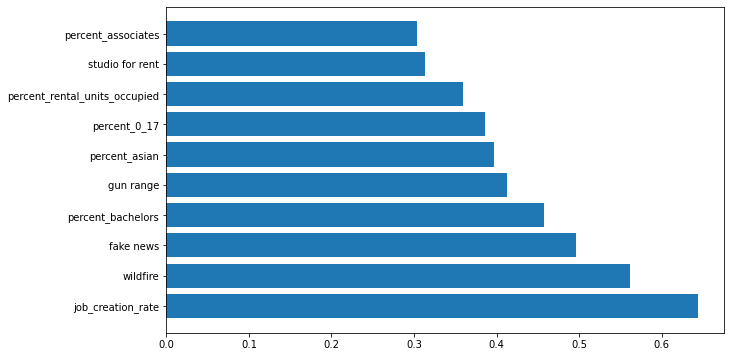


Got an mse at 0.0025 in epoch 69 and stopped training



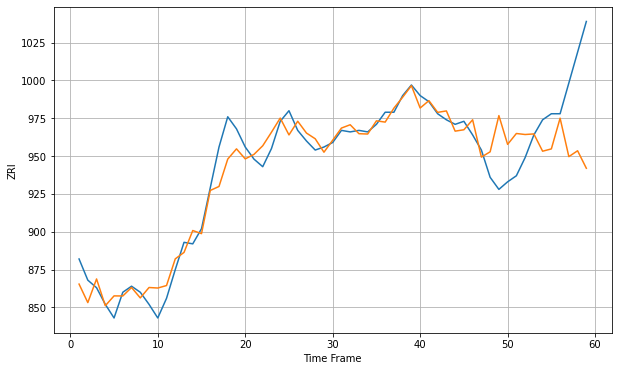

Wall time: 9.99 s
12307 9.578705480410678 42.1287165280853


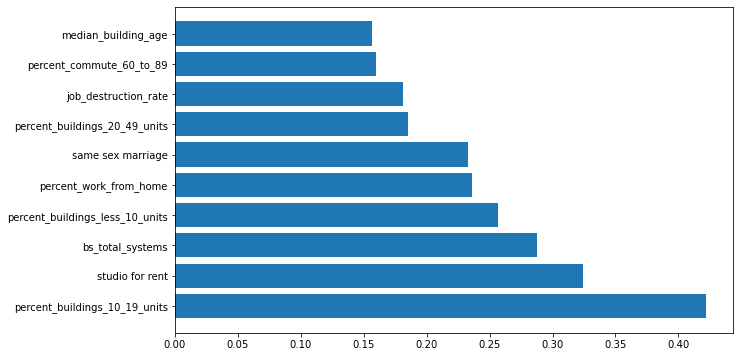


Got an mse at 0.0025 in epoch 119 and stopped training



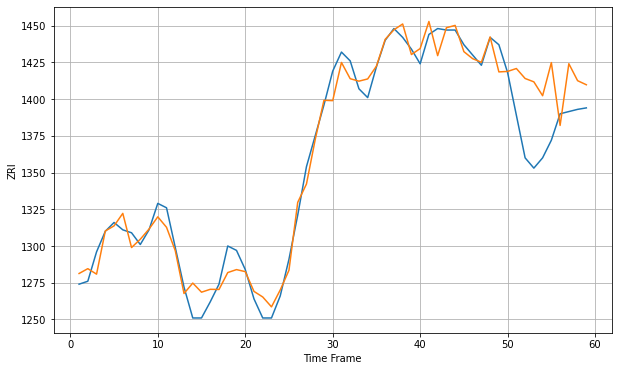

Wall time: 11.5 s
12401 9.667174410830532 34.2241528891514


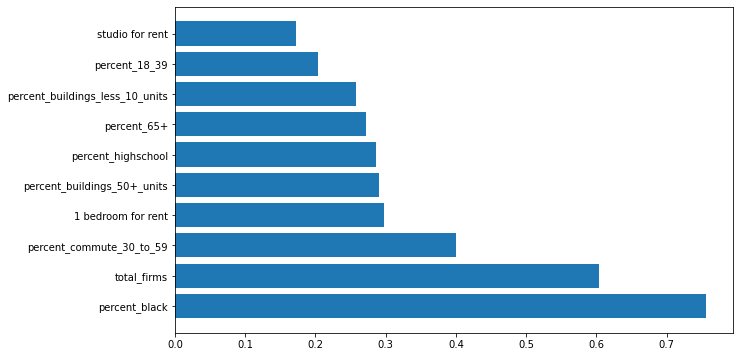


Got an mse at 0.0022 in epoch 22 and stopped training



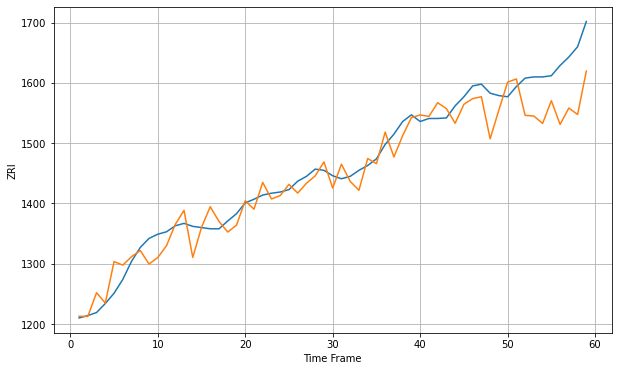

Wall time: 8.54 s
12508 22.187065591142275 70.0529617039669


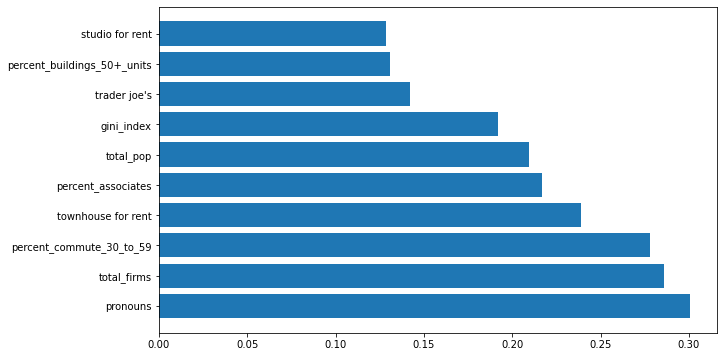


Got an mse at 0.0025 in epoch 94 and stopped training



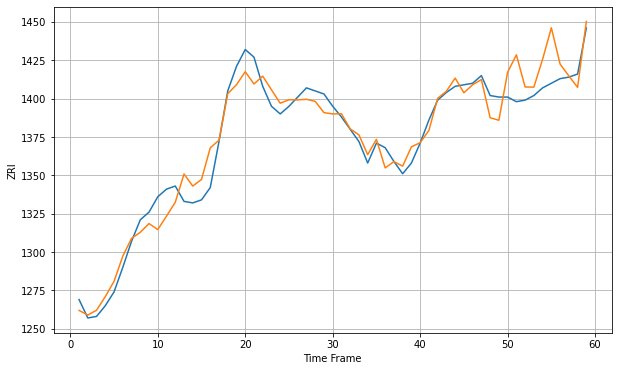

Wall time: 10.8 s
12550 9.386597655579449 17.26195443890282


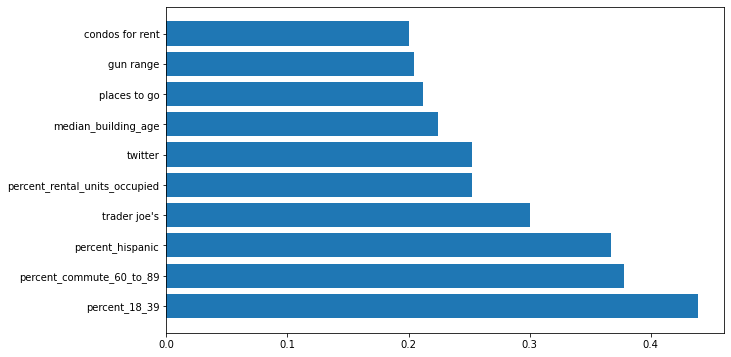


Got an mse at 0.0025 in epoch 29 and stopped training



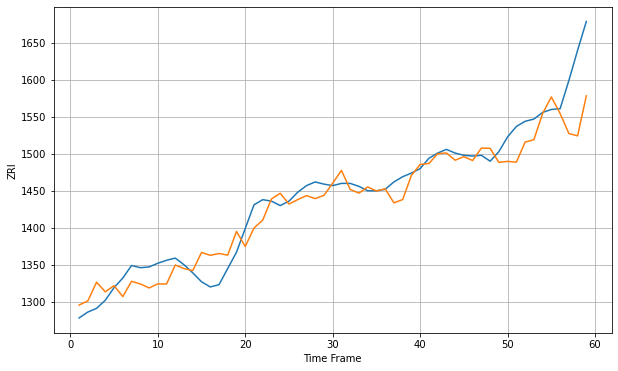

Wall time: 8.92 s
12590 19.981174311670486 53.59054382619095


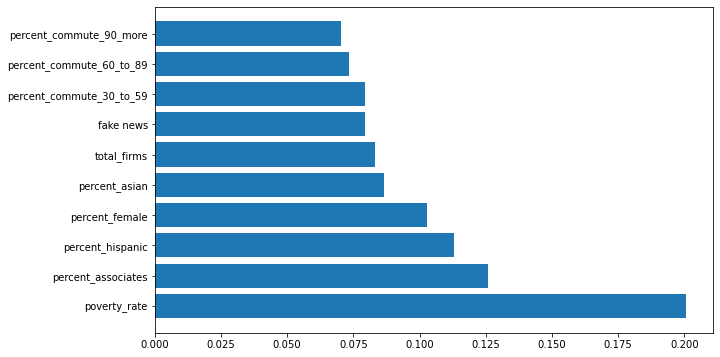

In [ ]:
score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "importance":[]};
with tf.device('/cpu:0'):
    # for ZONE in zip_ids:
    for ZONE in zip_ids[START_NUM:END_NUM]:
        %time M_train, M_test, model, scaler, series_transformed =\
        NN_test(ZONE, termination=0.0025, plot=True);
        print(ZONE, M_train, M_test);

        score_dict["zip"].append(ZONE);
        score_dict["RMSE_train"].append(M_train);
        score_dict["RMSE_test"].append(M_test);
        
        # Computing the feature importance
        
        results, actual = NN_forecast(model, series_transformed);
        mse = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5;
        perm_importance = [];
        TRIALS = 2;
        PLOT_IMPORTANCE = True;
        
        for i in range(1, len(feature_name)):
            mse_feat = [];
            for _ in range(TRIALS):
                seq_perm = series_transformed.copy();
                seq_perm[:, i] = np.random.permutation(seq_perm[:,i])
                results, actual = NN_forecast(model, seq_perm);
                mse_feat.append(mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5);
                
            perm_importance.append(sum(mse_feat)/TRIALS/mse - 1.0);
        
        importance = pd.DataFrame({"Feature": feature_name[1:], "Importance": perm_importance});
        importance.sort_values("Importance", ascending = False, inplace = True);
        
        plt.figure(figsize=(10, 6));
        plt.barh(importance["Feature"][:10], importance["Importance"][:10]);
        plt.show();
        
        score_dict["importance"].append(perm_importance);

In [16]:
print(sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]));

37.21978891151454


In [17]:
test = pd.DataFrame(score_dict);
test.to_csv('NN_feature_window_1_overoverfit_importance_3.csv', index = False);